# Mini Project 3 - NLP

**Purpose:** Apply the Word Embedding & Unsupervised Learning to detect Fake News

My topic of interest is "vaccine"

## Import Libraries 

In [275]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

# preprocessing
import string
import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS

import nltk
from nltk.stem.porter import *
import en_core_web_lg
from collections import Counter
# twitter
import tweepy 
import json
from pandas.io.json import json_normalize
import pprint

#gensim library: Word2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

#vizualization
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(20,8)})

#models
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

#Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import multiprocessing #speed up computing
import os #saving & loading models

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

# Data Source: Twitter

## Autentication 

In [276]:
# authenticate Twitter
path_auth = 'dat/auth_twitter.json'
auth = json.loads(open(path_auth).read())

# For debugging only:
# pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(auth)

consumer_key = auth['consumer_key']
consumer_secret = auth['consumer_secret']
access_token = auth['access_token']
access_token_secret = auth['access_token_secret']

In [277]:
# connect to Twitter using the Tweepy library
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

## Getting Tweets 

**Tweet Object**

This source link (below) tells us that the content of each tweet is in 'text'. So that is what we will extract

    {
     "created_at": "Wed Oct 10 20:19:24 +0000 2018",
     "id": 1050118621198921728,
     "id_str": "1050118621198921728",
     "text": "To make room for more expression, we will now count all emojis as equal—including those with gender‍‍‍ ‍‍and skin t… https://t.co/MkGjXf9aXm",
     "user": {},  
     "entities": {}
    }

Source: https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet

In [278]:
# Collect tweets
search_words = "vaccine -filter:retweets"
date_since = "2021-03-17"
date_until = "2021-03-18"

tweets = tweepy.Cursor(api.search, q=search_words, lang="en", until=date_until, since=date_since, tweet_mode='extended').items(10)  # checking if full text is collected

# Iterate and print tweets
for tweet in tweets:
    vacc_tweets = str(print(tweet.full_text))
    
vacc_tweets

@PoliticsForAlI It’s to tell us the vaccine has hit 25 million, so we can all chant “all praise be to Matt’. He will have the Cheshire Cat grin all over his face.
Got my first dose vaccine today. Praying for no side effects.
To Trump. Your message about the vaccine is too little too late. You opened the barn doors and ushered all the Covid out to destroy the country. We are so over you.
@RealDiscoDonnie Do you need the vaccine to get in??
Vaccine protest so your trek thru New kgn might be delayed https://t.co/xUknjFBXNy
@ArleneDickinson Can't even get a appointment  for the vaccine in my area. Still doing 80&amp;85 plus. Good luck to you @ArleneDickinson
.@NYGovCuomo invokes the name of Hon. David Dinkins as he gets  his vaccine at Mt. Neboh Baptist Church in Harlem. @1010WINS
Coronavirus vaccine side effects: Swollen glands can ‘last for around 10 days’

https://t.co/z57Xe2RgzR
They couldn't give me this vaccine before i left p*h 😭😭
And like it's not about me. It's not. I'm lucky. I C

'None'

In [280]:
# Iterate and print tweet id and text 
tweets = tweepy.Cursor(api.search, q=search_words, lang="en", until=date_until, since=date_since, tweet_mode='extended').items(1000) # getting more tweets

vacc_tweet_list = [tweet.full_text for tweet in tweets]
vacc_tweet_list

['@tomhfh If the UK was still in the EU and unable to draw a comparative comparison,would we just think that everything is going well with the vaccine roll out?',
 '@Duckbird3 @RickRoseland But the AZ vaccine rollout is being halted in sovereign nations.\n\nAnd the 27 agreed to work together to share out vaccine between larger and smaller states.\n\nDo you have a clue about how the EU works?',
 'When I get my vaccine in April the person administering the shot better be dressed as the Easter bunny! https://t.co/bvFqbgDB5Y',
 'I want to get a vaccine :(',
 'A woman gave birth to a baby with Covid antibodies b/c she got the vaccine. I’m torn right now. I’m at a higher risk anyway because I work in schools that’s are fully F2F. But there’s not a lot of research😭',
 'More than 3.64 Crore #COVID19 vaccine doses administered, so far. 14.03 lakh #vaccine doses given till 7 pm today: #ministryofhousingandurbandevelopmentofHealth',
 '... the SAFETY of vaccines, and our wish to travel again and i

In [ ]:
# save list into dictionary (to save my skin - in case I exceed request limit)
vacc_raw_tweets = { "text": vacc_tweet_list }

In [ ]:
# save list into json file
with open('vacc_raw_tweets/list-2021-03-17.json', 'w') as fp:
    json.dump(vacc_raw_tweets, fp)

In [281]:
## because I can only get 1000 tweets at one go, I saved it in batches -
# there are a total of 5 files saved:
path_data_1 = 'vacc_raw_tweets/list-2021-03-09.json'
path_data_2 = 'vacc_raw_tweets/list-2021-03-11.json'
path_data_3 = 'vacc_raw_tweets/list-2021-03-13.json'
path_data_4 = 'vacc_raw_tweets/list-2021-03-15.json'
path_data_5 = 'vacc_raw_tweets/list-2021-03-17.json'

# search and open tweet files
vacc_tweet_data_1 = json.loads(open(path_data_1).read())
vacc_tweet_data_2 = json.loads(open(path_data_2).read())
vacc_tweet_data_3 = json.loads(open(path_data_3).read())
vacc_tweet_data_4 = json.loads(open(path_data_4).read())
vacc_tweet_data_5 = json.loads(open(path_data_5).read())

In [282]:
# Putting tweets list into a dataframe
pd.set_option("max_colwidth", 1200)  # increase pandas df colwidth, which is the max tweet length

# putting each file into df
tweet_df_1 = pd.DataFrame(vacc_tweet_data_1, columns=['text'])
tweet_df_2 = pd.DataFrame(vacc_tweet_data_2, columns=['text'])
tweet_df_3 = pd.DataFrame(vacc_tweet_data_3, columns=['text'])
tweet_df_4 = pd.DataFrame(vacc_tweet_data_4, columns=['text'])
tweet_df_5 = pd.DataFrame(vacc_tweet_data_5, columns=['text'])

# combined df
tweet_df = pd.concat([tweet_df_1, tweet_df_2, tweet_df_3, tweet_df_4, tweet_df_5]) 
tweet_df.head(10)

text
0                                  Lower covid cases doesn’t automatically mean open everything back up it means let’s start mass handouts of the vaccine for everyone to ensure we can have a summer https://t.co/9ZF71rwyJd
1                                                                                                                                           @porkroll4life @BCNJ_VaccineBot I track Ocean County. Stick with me for that one.
2                                                                                                                                                         @stephenasmith A jury found the vaccine “undisputed” in every case.
3                                                                                                                                              Why are appointments for the covid vaccine so hard to get in Murfreesboro, Tn?
4                                                                                                                                                  @wanderlusterers i scheduled my vaccine already!! so we can kithhh soon :*
5                                                                                                                                                                                       I can finally get this vaccine legooo
6            @tracyvwilson Guaranteed that I’ll be wearing masks for at least another year after the vaccine. I used to live in Seoul S. Korea and they wore masks all over the place.  I should’ve taken the hint back then.
7  PR colleagues: Learn more about the communications strategy behind Indiana's COVID-19 vaccine distribution plan. There's still time to register for Thursday's virtual luncheon from @PRSAHoosier! https://t.co/YYO22J3R7F
8                                                                                                                                                                  Just got my first vaccine dose, thank you sweet baby Jesus
9                                                                                 In the interest of full disclosure, after long hard thoughts, I’ve decided I’m getting the COVID-19 Vaccine. Today. https://t.co/cSrVawe9oL

In [283]:
tweet_df.shape

(5000, 1)

# Data Cleaning - Regex

## Remove URLs 

In [284]:
# Using regex to remove URLs (test)
text = 'In the interest of full disclosure, after long hard thoughts, I’ve decided I’m getting the COVID-19 Vaccine. Today. https://t.co/cSrVawe9oL'
text = re.sub(r'http\S+', '', text)
text

'In the interest of full disclosure, after long hard thoughts, I’ve decided I’m getting the COVID-19 Vaccine. Today. '

In [285]:
# Build a function to remove URL
def remove_url(text):
    text = re.sub(r'http\S+', '', text)
    return text

In [286]:
# Applying function to dataframe
tweet_df['clean'] = tweet_df['text'].apply(remove_url)
tweet_df.head(10)

text  \
0                                  Lower covid cases doesn’t automatically mean open everything back up it means let’s start mass handouts of the vaccine for everyone to ensure we can have a summer https://t.co/9ZF71rwyJd   
1                                                                                                                                           @porkroll4life @BCNJ_VaccineBot I track Ocean County. Stick with me for that one.   
2                                                                                                                                                         @stephenasmith A jury found the vaccine “undisputed” in every case.   
3                                                                                                                                              Why are appointments for the covid vaccine so hard to get in Murfreesboro, Tn?   
4                                                                                                                                                  @wanderlusterers i scheduled my vaccine already!! so we can kithhh soon :*   
5                                                                                                                                                                                       I can finally get this vaccine legooo   
6            @tracyvwilson Guaranteed that I’ll be wearing masks for at least another year after the vaccine. I used to live in Seoul S. Korea and they wore masks all over the place.  I should’ve taken the hint back then.   
7  PR colleagues: Learn more about the communications strategy behind Indiana's COVID-19 vaccine distribution plan. There's still time to register for Thursday's virtual luncheon from @PRSAHoosier! https://t.co/YYO22J3R7F   
8                                                                                                                                                                  Just got my first vaccine dose, thank you sweet baby Jesus   
9                                                                                 In the interest of full disclosure, after long hard thoughts, I’ve decided I’m getting the COVID-19 Vaccine. Today. https://t.co/cSrVawe9oL   

                                                                                                                                                                                                              clean  
0                                               Lower covid cases doesn’t automatically mean open everything back up it means let’s start mass handouts of the vaccine for everyone to ensure we can have a summer   
1                                                                                                                                 @porkroll4life @BCNJ_VaccineBot I track Ocean County. Stick with me for that one.  
2                                                                                                                                               @stephenasmith A jury found the vaccine “undisputed” in every case.  
3                                                                                                                                    Why are appointments for the covid vaccine so hard to get in Murfreesboro, Tn?  
4                                                                                                                                        @wanderlusterers i scheduled my vaccine already!! so we can kithhh soon :*  
5                                                                                                                                                                             I can finally get this vaccine legooo  
6  @tracyvwilson Guaranteed that I’ll be wearing masks for at least another year after the vaccine. I used to live in Seoul S. Korea and they wore masks all over the place.  I should’ve taken the hint back then.  
7               PR colleagues

## Remove @mentions

In [287]:
# Using regex to remove @mentions (test)
text = '@stephenasmith A jury found the vaccine “undisputed” in every case.'
text = re.sub(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)', '', text)    # remove mentions (even with underscore)
text

' A jury found the vaccine “undisputed” in every case.'

In [288]:
# Build a function to remove @mentions
def remove_mentions(text):
    text = re.sub(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)', '', text) 
    return text

In [289]:
# Applying function to dataframe
tweet_df['clean'] = tweet_df['clean'].apply(remove_mentions)
tweet_df.head(10)

text  \
0                                  Lower covid cases doesn’t automatically mean open everything back up it means let’s start mass handouts of the vaccine for everyone to ensure we can have a summer https://t.co/9ZF71rwyJd   
1                                                                                                                                           @porkroll4life @BCNJ_VaccineBot I track Ocean County. Stick with me for that one.   
2                                                                                                                                                         @stephenasmith A jury found the vaccine “undisputed” in every case.   
3                                                                                                                                              Why are appointments for the covid vaccine so hard to get in Murfreesboro, Tn?   
4                                                                                                                                                  @wanderlusterers i scheduled my vaccine already!! so we can kithhh soon :*   
5                                                                                                                                                                                       I can finally get this vaccine legooo   
6            @tracyvwilson Guaranteed that I’ll be wearing masks for at least another year after the vaccine. I used to live in Seoul S. Korea and they wore masks all over the place.  I should’ve taken the hint back then.   
7  PR colleagues: Learn more about the communications strategy behind Indiana's COVID-19 vaccine distribution plan. There's still time to register for Thursday's virtual luncheon from @PRSAHoosier! https://t.co/YYO22J3R7F   
8                                                                                                                                                                  Just got my first vaccine dose, thank you sweet baby Jesus   
9                                                                                 In the interest of full disclosure, after long hard thoughts, I’ve decided I’m getting the COVID-19 Vaccine. Today. https://t.co/cSrVawe9oL   

                                                                                                                                                                                                 clean  
0                                  Lower covid cases doesn’t automatically mean open everything back up it means let’s start mass handouts of the vaccine for everyone to ensure we can have a summer   
1                                                                                                                                                    I track Ocean County. Stick with me for that one.  
2                                                                                                                                                 A jury found the vaccine “undisputed” in every case.  
3                                                                                                                       Why are appointments for the covid vaccine so hard to get in Murfreesboro, Tn?  
4                                                                                                                                            i scheduled my vaccine already!! so we can kithhh soon :*  
5                                                                                                                                                                I can finally get this vaccine legooo  
6   Guaranteed that I’ll be wearing masks for at least another year after the vaccine. I used to live in Seoul S. Korea and they wore masks all over the place.  I should’ve taken the hint back then.  
7              PR colleagues: Learn more about the communications strategy behind Indiana's COVID-19 vaccine distribution plan. There

## Remove New Lines '\n'

In [290]:
# Using regex to remove new lines '\n' (test)
text = 'i scheduled my vaccine already!! so we can kithhh soon :*\n\n'
text = re.sub('\\n', '', text)  
text

'i scheduled my vaccine already!! so we can kithhh soon :*'

In [291]:
# Build a function to remove new lines '\n'
def remove_newlines(text):
    text = re.sub('\\n', ' ', text) 
    return text

In [292]:
# Applying function to dataframe
tweet_df['clean'] = tweet_df['clean'].apply(remove_newlines)
tweet_df.head(10)

text  \
0                                  Lower covid cases doesn’t automatically mean open everything back up it means let’s start mass handouts of the vaccine for everyone to ensure we can have a summer https://t.co/9ZF71rwyJd   
1                                                                                                                                           @porkroll4life @BCNJ_VaccineBot I track Ocean County. Stick with me for that one.   
2                                                                                                                                                         @stephenasmith A jury found the vaccine “undisputed” in every case.   
3                                                                                                                                              Why are appointments for the covid vaccine so hard to get in Murfreesboro, Tn?   
4                                                                                                                                                  @wanderlusterers i scheduled my vaccine already!! so we can kithhh soon :*   
5                                                                                                                                                                                       I can finally get this vaccine legooo   
6            @tracyvwilson Guaranteed that I’ll be wearing masks for at least another year after the vaccine. I used to live in Seoul S. Korea and they wore masks all over the place.  I should’ve taken the hint back then.   
7  PR colleagues: Learn more about the communications strategy behind Indiana's COVID-19 vaccine distribution plan. There's still time to register for Thursday's virtual luncheon from @PRSAHoosier! https://t.co/YYO22J3R7F   
8                                                                                                                                                                  Just got my first vaccine dose, thank you sweet baby Jesus   
9                                                                                 In the interest of full disclosure, after long hard thoughts, I’ve decided I’m getting the COVID-19 Vaccine. Today. https://t.co/cSrVawe9oL   

                                                                                                                                                                                                 clean  
0                                  Lower covid cases doesn’t automatically mean open everything back up it means let’s start mass handouts of the vaccine for everyone to ensure we can have a summer   
1                                                                                                                                                    I track Ocean County. Stick with me for that one.  
2                                                                                                                                                 A jury found the vaccine “undisputed” in every case.  
3                                                                                                                       Why are appointments for the covid vaccine so hard to get in Murfreesboro, Tn?  
4                                                                                                                                            i scheduled my vaccine already!! so we can kithhh soon :*  
5                                                                                                                                                                I can finally get this vaccine legooo  
6   Guaranteed that I’ll be wearing masks for at least another year after the vaccine. I used to live in Seoul S. Korea and they wore masks all over the place.  I should’ve taken the hint back then.  
7              PR colleagues: Learn more about the communications strategy behind Indiana's COVID-19 vaccine distribution plan. There

## Remove #Hashtags 

In [293]:
# Using regex to remove new lines '\n' (test)
text = 'Just got my first vaccine dose, thank you sweet baby Jesus #thankful'
text = re.sub(r'\s#\w+', '', text)  
text

'Just got my first vaccine dose, thank you sweet baby Jesus'

In [294]:
# Build a function to remove new lines '\n'
def remove_hashtags(text):
    text = re.sub('\s#\w+', ' ', text) 
    return text

In [295]:
# Applying function to dataframe
tweet_df['clean'] = tweet_df['clean'].apply(remove_hashtags)
tweet_df.head(10)

text  \
0                                  Lower covid cases doesn’t automatically mean open everything back up it means let’s start mass handouts of the vaccine for everyone to ensure we can have a summer https://t.co/9ZF71rwyJd   
1                                                                                                                                           @porkroll4life @BCNJ_VaccineBot I track Ocean County. Stick with me for that one.   
2                                                                                                                                                         @stephenasmith A jury found the vaccine “undisputed” in every case.   
3                                                                                                                                              Why are appointments for the covid vaccine so hard to get in Murfreesboro, Tn?   
4                                                                                                                                                  @wanderlusterers i scheduled my vaccine already!! so we can kithhh soon :*   
5                                                                                                                                                                                       I can finally get this vaccine legooo   
6            @tracyvwilson Guaranteed that I’ll be wearing masks for at least another year after the vaccine. I used to live in Seoul S. Korea and they wore masks all over the place.  I should’ve taken the hint back then.   
7  PR colleagues: Learn more about the communications strategy behind Indiana's COVID-19 vaccine distribution plan. There's still time to register for Thursday's virtual luncheon from @PRSAHoosier! https://t.co/YYO22J3R7F   
8                                                                                                                                                                  Just got my first vaccine dose, thank you sweet baby Jesus   
9                                                                                 In the interest of full disclosure, after long hard thoughts, I’ve decided I’m getting the COVID-19 Vaccine. Today. https://t.co/cSrVawe9oL   

                                                                                                                                                                                                 clean  
0                                  Lower covid cases doesn’t automatically mean open everything back up it means let’s start mass handouts of the vaccine for everyone to ensure we can have a summer   
1                                                                                                                                                    I track Ocean County. Stick with me for that one.  
2                                                                                                                                                 A jury found the vaccine “undisputed” in every case.  
3                                                                                                                       Why are appointments for the covid vaccine so hard to get in Murfreesboro, Tn?  
4                                                                                                                                            i scheduled my vaccine already!! so we can kithhh soon :*  
5                                                                                                                                                                I can finally get this vaccine legooo  
6   Guaranteed that I’ll be wearing masks for at least another year after the vaccine. I used to live in Seoul S. Korea and they wore masks all over the place.  I should’ve taken the hint back then.  
7              PR colleagues: Learn more about the communications strategy behind Indiana's COVID-19 vaccine distribution plan. There

## Remove Punctuations 

In [296]:
# Using regex to remove punctuations (test)
text = 'scheduled my vaccine already!! so we can kithhh soon :*'
text = re.sub(r'[^\w\d\s\-]+', '', text)  
text

'scheduled my vaccine already so we can kithhh soon '

In [297]:
# Build a function to remove punctuations (without hyphens '-')
def remove_punctuations(text):
    text = re.sub(r'[^\w\d\s\-]+', '', text) 
    return text

In [298]:
# Applying function to dataframe
tweet_df['clean'] = tweet_df['clean'].apply(remove_punctuations)
tweet_df.head(10)

text  \
0                                  Lower covid cases doesn’t automatically mean open everything back up it means let’s start mass handouts of the vaccine for everyone to ensure we can have a summer https://t.co/9ZF71rwyJd   
1                                                                                                                                           @porkroll4life @BCNJ_VaccineBot I track Ocean County. Stick with me for that one.   
2                                                                                                                                                         @stephenasmith A jury found the vaccine “undisputed” in every case.   
3                                                                                                                                              Why are appointments for the covid vaccine so hard to get in Murfreesboro, Tn?   
4                                                                                                                                                  @wanderlusterers i scheduled my vaccine already!! so we can kithhh soon :*   
5                                                                                                                                                                                       I can finally get this vaccine legooo   
6            @tracyvwilson Guaranteed that I’ll be wearing masks for at least another year after the vaccine. I used to live in Seoul S. Korea and they wore masks all over the place.  I should’ve taken the hint back then.   
7  PR colleagues: Learn more about the communications strategy behind Indiana's COVID-19 vaccine distribution plan. There's still time to register for Thursday's virtual luncheon from @PRSAHoosier! https://t.co/YYO22J3R7F   
8                                                                                                                                                                  Just got my first vaccine dose, thank you sweet baby Jesus   
9                                                                                 In the interest of full disclosure, after long hard thoughts, I’ve decided I’m getting the COVID-19 Vaccine. Today. https://t.co/cSrVawe9oL   

                                                                                                                                                                                           clean  
0                              Lower covid cases doesnt automatically mean open everything back up it means lets start mass handouts of the vaccine for everyone to ensure we can have a summer   
1                                                                                                                                                I track Ocean County Stick with me for that one  
2                                                                                                                                              A jury found the vaccine undisputed in every case  
3                                                                                                                   Why are appointments for the covid vaccine so hard to get in Murfreesboro Tn  
4                                                                                                                                          i scheduled my vaccine already so we can kithhh soon   
5                                                                                                                                                          I can finally get this vaccine legooo  
6   Guaranteed that Ill be wearing masks for at least another year after the vaccine I used to live in Seoul S Korea and they wore masks all over the place  I shouldve taken the hint back then  
7              PR colleagues Learn more about the communications strategy behind Indianas COVID-19 vaccine distribution plan Theres still time to register for Thursdays virtual lunc

## Lowercase 

In [299]:
# convert to lower case (test)
text = 'I track Ocean County. Stick with me for that one.'
text = text.lower()
text

'i track ocean county. stick with me for that one.'

In [300]:
# Build a function to lower case
def lower_case(text):
    text = text.lower()
    return text

In [301]:
# Applying function to dataframe
tweet_df['clean'] = tweet_df['clean'].apply(lower_case)
tweet_df.head(10)

text  \
0                                  Lower covid cases doesn’t automatically mean open everything back up it means let’s start mass handouts of the vaccine for everyone to ensure we can have a summer https://t.co/9ZF71rwyJd   
1                                                                                                                                           @porkroll4life @BCNJ_VaccineBot I track Ocean County. Stick with me for that one.   
2                                                                                                                                                         @stephenasmith A jury found the vaccine “undisputed” in every case.   
3                                                                                                                                              Why are appointments for the covid vaccine so hard to get in Murfreesboro, Tn?   
4                                                                                                                                                  @wanderlusterers i scheduled my vaccine already!! so we can kithhh soon :*   
5                                                                                                                                                                                       I can finally get this vaccine legooo   
6            @tracyvwilson Guaranteed that I’ll be wearing masks for at least another year after the vaccine. I used to live in Seoul S. Korea and they wore masks all over the place.  I should’ve taken the hint back then.   
7  PR colleagues: Learn more about the communications strategy behind Indiana's COVID-19 vaccine distribution plan. There's still time to register for Thursday's virtual luncheon from @PRSAHoosier! https://t.co/YYO22J3R7F   
8                                                                                                                                                                  Just got my first vaccine dose, thank you sweet baby Jesus   
9                                                                                 In the interest of full disclosure, after long hard thoughts, I’ve decided I’m getting the COVID-19 Vaccine. Today. https://t.co/cSrVawe9oL   

                                                                                                                                                                                           clean  
0                              lower covid cases doesnt automatically mean open everything back up it means lets start mass handouts of the vaccine for everyone to ensure we can have a summer   
1                                                                                                                                                i track ocean county stick with me for that one  
2                                                                                                                                              a jury found the vaccine undisputed in every case  
3                                                                                                                   why are appointments for the covid vaccine so hard to get in murfreesboro tn  
4                                                                                                                                          i scheduled my vaccine already so we can kithhh soon   
5                                                                                                                                                          i can finally get this vaccine legooo  
6   guaranteed that ill be wearing masks for at least another year after the vaccine i used to live in seoul s korea and they wore masks all over the place  i shouldve taken the hint back then  
7              pr colleagues learn more about the communications strategy behind indianas covid-19 vaccine distribution plan theres still time to register for thursdays virtual lunc

## Remove Whitespaces

In [302]:
# convert to remove whitespaces (Leading & Trailing) (test)
text = "  i track ocean county   stick with me for that one    "
text = re.sub(r'^\s+|\s+$', '', text) 
text

'i track ocean county   stick with me for that one'

In [303]:
# Build a function to remove punctuations (without hyphens '-')
def remove_whitespaces(text):
    text = re.sub(r'^\s+|\s+$', '', text) 
    return text

In [304]:
# Applying function to dataframe
tweet_df['clean'] = tweet_df['clean'].apply(remove_whitespaces)
tweet_df.head(10)

text  \
0                                  Lower covid cases doesn’t automatically mean open everything back up it means let’s start mass handouts of the vaccine for everyone to ensure we can have a summer https://t.co/9ZF71rwyJd   
1                                                                                                                                           @porkroll4life @BCNJ_VaccineBot I track Ocean County. Stick with me for that one.   
2                                                                                                                                                         @stephenasmith A jury found the vaccine “undisputed” in every case.   
3                                                                                                                                              Why are appointments for the covid vaccine so hard to get in Murfreesboro, Tn?   
4                                                                                                                                                  @wanderlusterers i scheduled my vaccine already!! so we can kithhh soon :*   
5                                                                                                                                                                                       I can finally get this vaccine legooo   
6            @tracyvwilson Guaranteed that I’ll be wearing masks for at least another year after the vaccine. I used to live in Seoul S. Korea and they wore masks all over the place.  I should’ve taken the hint back then.   
7  PR colleagues: Learn more about the communications strategy behind Indiana's COVID-19 vaccine distribution plan. There's still time to register for Thursday's virtual luncheon from @PRSAHoosier! https://t.co/YYO22J3R7F   
8                                                                                                                                                                  Just got my first vaccine dose, thank you sweet baby Jesus   
9                                                                                 In the interest of full disclosure, after long hard thoughts, I’ve decided I’m getting the COVID-19 Vaccine. Today. https://t.co/cSrVawe9oL   

                                                                                                                                                                                          clean  
0                              lower covid cases doesnt automatically mean open everything back up it means lets start mass handouts of the vaccine for everyone to ensure we can have a summer  
1                                                                                                                                               i track ocean county stick with me for that one  
2                                                                                                                                             a jury found the vaccine undisputed in every case  
3                                                                                                                  why are appointments for the covid vaccine so hard to get in murfreesboro tn  
4                                                                                                                                          i scheduled my vaccine already so we can kithhh soon  
5                                                                                                                                                         i can finally get this vaccine legooo  
6  guaranteed that ill be wearing masks for at least another year after the vaccine i used to live in seoul s korea and they wore masks all over the place  i shouldve taken the hint back then  
7               pr colleagues learn more about the communications strategy behind indianas covid-19 vaccine distribution plan theres still time to register for thursdays virtual luncheon fr

## Remove Digits 

In [305]:
# removing digits (test)
text = 'ive decided im getting the covid-19 vaccine today'
text = re.sub(r'\d+', '', text)
text

'ive decided im getting the covid- vaccine today'

In [306]:
# Build a function to remove digits
def remove_digits(text):
    text = re.sub(r'\d+', '', text) 
    return text

In [307]:
# Applying function to dataframe
tweet_df['clean'] = tweet_df['clean'].apply(remove_digits)
tweet_df.head(10)

text  \
0                                  Lower covid cases doesn’t automatically mean open everything back up it means let’s start mass handouts of the vaccine for everyone to ensure we can have a summer https://t.co/9ZF71rwyJd   
1                                                                                                                                           @porkroll4life @BCNJ_VaccineBot I track Ocean County. Stick with me for that one.   
2                                                                                                                                                         @stephenasmith A jury found the vaccine “undisputed” in every case.   
3                                                                                                                                              Why are appointments for the covid vaccine so hard to get in Murfreesboro, Tn?   
4                                                                                                                                                  @wanderlusterers i scheduled my vaccine already!! so we can kithhh soon :*   
5                                                                                                                                                                                       I can finally get this vaccine legooo   
6            @tracyvwilson Guaranteed that I’ll be wearing masks for at least another year after the vaccine. I used to live in Seoul S. Korea and they wore masks all over the place.  I should’ve taken the hint back then.   
7  PR colleagues: Learn more about the communications strategy behind Indiana's COVID-19 vaccine distribution plan. There's still time to register for Thursday's virtual luncheon from @PRSAHoosier! https://t.co/YYO22J3R7F   
8                                                                                                                                                                  Just got my first vaccine dose, thank you sweet baby Jesus   
9                                                                                 In the interest of full disclosure, after long hard thoughts, I’ve decided I’m getting the COVID-19 Vaccine. Today. https://t.co/cSrVawe9oL   

                                                                                                                                                                                          clean  
0                              lower covid cases doesnt automatically mean open everything back up it means lets start mass handouts of the vaccine for everyone to ensure we can have a summer  
1                                                                                                                                               i track ocean county stick with me for that one  
2                                                                                                                                             a jury found the vaccine undisputed in every case  
3                                                                                                                  why are appointments for the covid vaccine so hard to get in murfreesboro tn  
4                                                                                                                                          i scheduled my vaccine already so we can kithhh soon  
5                                                                                                                                                         i can finally get this vaccine legooo  
6  guaranteed that ill be wearing masks for at least another year after the vaccine i used to live in seoul s korea and they wore masks all over the place  i shouldve taken the hint back then  
7                 pr colleagues learn more about the communications strategy behind indianas covid- vaccine distribution plan theres still time to register for thursdays virtual luncheon fr

## Cleaned Tweets 

In [308]:
tweet_df[['clean']].head(10)

clean
0                              lower covid cases doesnt automatically mean open everything back up it means lets start mass handouts of the vaccine for everyone to ensure we can have a summer
1                                                                                                                                               i track ocean county stick with me for that one
2                                                                                                                                             a jury found the vaccine undisputed in every case
3                                                                                                                  why are appointments for the covid vaccine so hard to get in murfreesboro tn
4                                                                                                                                          i scheduled my vaccine already so we can kithhh soon
5                                                                                                                                                         i can finally get this vaccine legooo
6  guaranteed that ill be wearing masks for at least another year after the vaccine i used to live in seoul s korea and they wore masks all over the place  i shouldve taken the hint back then
7                 pr colleagues learn more about the communications strategy behind indianas covid- vaccine distribution plan theres still time to register for thursdays virtual luncheon from
8                                                                                                                                     just got my first vaccine dose thank you sweet baby jesus
9                                                                                   in the interest of full disclosure after long hard thoughts ive decided im getting the covid- vaccine today

In [309]:
tweet_df.shape

(5000, 2)

# Data Processing - spaCy

In [310]:
# initiate nlp class for english
nlp = spacy.load("en_core_web_lg")
# to tokenize the tweets

In [311]:
doc = nlp(str(tweet_df[['clean']]))
doc

                                                                                                                                                                                                                                                                     clean
0                                                                                                         lower covid cases doesnt automatically mean open everything back up it means lets start mass handouts of the vaccine for everyone to ensure we can have a summer
1                                                                                                                                                                                                                          i track ocean county stick with me for that one
2                                                                                                                                                                                                      

### Testing 

In [312]:
# process the text (taking one test sample)
sentence1 = nlp("a jury found the vaccine undisputed in every case")
print(type(sentence1))
print(len(sentence1))

<class 'spacy.tokens.doc.Doc'>
9


In [313]:
# tokenise the text (taking one test sample)
for token in sentence1:
    print(f"token:{token}\t tag:{token.tag_}\t\tPOS:{token.pos_}\t\t text:'{token.text}' \tlemma:{token.lemma_}\t \tstopwords:{token.is_stop}\t")

token:a	 tag:DT		POS:DET		 text:'a' 	lemma:a	 	stopwords:True	
token:jury	 tag:NN		POS:NOUN		 text:'jury' 	lemma:jury	 	stopwords:False	
token:found	 tag:VBD		POS:VERB		 text:'found' 	lemma:find	 	stopwords:False	
token:the	 tag:DT		POS:DET		 text:'the' 	lemma:the	 	stopwords:True	
token:vaccine	 tag:NN		POS:NOUN		 text:'vaccine' 	lemma:vaccine	 	stopwords:False	
token:undisputed	 tag:VBN		POS:VERB		 text:'undisputed' 	lemma:undispute	 	stopwords:False	
token:in	 tag:IN		POS:ADP		 text:'in' 	lemma:in	 	stopwords:True	
token:every	 tag:DT		POS:DET		 text:'every' 	lemma:every	 	stopwords:True	
token:case	 tag:NN		POS:NOUN		 text:'case' 	lemma:case	 	stopwords:False	


In [314]:
# testing 2nd example text
sentence2 = nlp("just got my first vaccine dose thank you sweet baby jesus")
print(type(sentence2))
print(len(sentence2))

<class 'spacy.tokens.doc.Doc'>
11


In [315]:
# recognising entities
for entity in sentence2.ents:
    print(entity.text + ' - ' + entity.label_ + ' - ' + str(spacy.explain(entity.label_)))

first - ORDINAL - "first", "second", etc.


In [316]:
# recognising nouns
for noun in sentence2.noun_chunks:
    print(noun.text)

my first vaccine dose
you


## Remove Stopwords 

In [317]:
# get stopwords, to be removed
def get_stopwords():
    stopwords = []

    for token in doc:
        if token.is_stop == True:
            stopwords.append(token.text)
    # Convert to set for performance
    stopwords_set = set(stopwords)
    return stopwords_set

stopwords = get_stopwords()

## Lemmatisation

In [318]:
# lemmatise dataframe
def lemmatize(text):
    """Perform lemmatization and stopword removal in the clean text
       Returns a list of lemmas
    """
    doc = nlp(text)
    lemma_list = [str(token.lemma_).lower() for token in doc
                  if token.is_alpha and token.text.lower() not in stopwords]
    return lemma_list

In [319]:
# applying both functions - from clean to processed column
tweet_df['processed'] = tweet_df['clean'].apply(lemmatize)
tweet_df[['clean', 'processed']].head(10)

clean  \
0                              lower covid cases doesnt automatically mean open everything back up it means lets start mass handouts of the vaccine for everyone to ensure we can have a summer   
1                                                                                                                                               i track ocean county stick with me for that one   
2                                                                                                                                             a jury found the vaccine undisputed in every case   
3                                                                                                                  why are appointments for the covid vaccine so hard to get in murfreesboro tn   
4                                                                                                                                          i scheduled my vaccine already so we can kithhh soon   
5                                                                                                                                                         i can finally get this vaccine legooo   
6  guaranteed that ill be wearing masks for at least another year after the vaccine i used to live in seoul s korea and they wore masks all over the place  i shouldve taken the hint back then   
7                 pr colleagues learn more about the communications strategy behind indianas covid- vaccine distribution plan theres still time to register for thursdays virtual luncheon from   
8                                                                                                                                     just got my first vaccine dose thank you sweet baby jesus   
9                                                                                   in the interest of full disclosure after long hard thoughts ive decided im getting the covid- vaccine today   

                                                                                                                                                            processed  
0                                                        [low, covid, case, nt, automatically, mean, open, mean, lets, start, mass, handout, vaccine, ensure, summer]  
1                                                                                                                                       [track, ocean, county, stick]  
2                                                                                                                              [jury, find, vaccine, undispute, case]  
3                                                                                                               [appointment, covid, vaccine, hard, murfreesboro, tn]  
4                                                                                                                                   [schedule, vaccine, kithhh, soon]  
5                                                                                                                                          [finally, vaccine, legooo]  
6  [guarantee, ill, be, wear, mask, at, least, another, year, after, vaccine, use, live, seoul, s, korea, wear, mask, all, over, place, should, ve, take, hint, then]  
7                [pr, colleague, learn, communication, strategy, behind, indianas, vaccine, distribution, plan, s, time, register, thursday, virtual, luncheon, from]  
8                                                                                                               [just, get, vaccine, dose, thank, sweet, baby, jesus]  
9                                                                        [interest, full, disclosure, after, long, hard, thought, ve, decide, m, get, vaccine, today]

## Processed Tweets 

In [320]:
tweet_df[['processed']].dtypes

processed    object
dtype: object

In [321]:
tweet_df[['processed']]  # each row is in a list, so need to convert to string

processed
0                                           [low, covid, case, nt, automatically, mean, open, mean, lets, start, mass, handout, vaccine, ensure, summer]
1                                                                                                                          [track, ocean, county, stick]
2                                                                                                                 [jury, find, vaccine, undispute, case]
3                                                                                                  [appointment, covid, vaccine, hard, murfreesboro, tn]
4                                                                                                                      [schedule, vaccine, kithhh, soon]
..                                                                                                                                                   ...
995  [ok, understand, co, morb, amp, travel, hrs, center, go, vaccine, come, believe, issue, locally, long, wait, choose, drive, feel, know, help, come]
996                                                                    [similar, reaction, pfizer, vaccine, person, hear, describe, experience, similar]
997                                             [stop, desantis, lie, refuse, public, information, distribution, vaccine, fcking, game, stop, act, like]
998                      [disgust, state, nt, care, essential, worker, work, entire, time, little, recognition, nt, consider, vaccine, age, range, come]
999                                                           [doubt, d, want, mix, type, vaccine, mention, success, rdna, nt, think, work, cross, type]

[5000 rows x 1 columns]

In [322]:
# Function to convert a list to string   
def listToString(s):      
    # initialize an empty string 
    str1 = " "     
    # return string   
    return (str1.join(s)) 

In [323]:
# applying function to convert to string
tweet_df['processed'] = tweet_df['processed'].apply(listToString)
tweet_df[['processed']].head(10)

processed
0                                             low covid case nt automatically mean open mean lets start mass handout vaccine ensure summer
1                                                                                                                 track ocean county stick
2                                                                                                         jury find vaccine undispute case
3                                                                                           appointment covid vaccine hard murfreesboro tn
4                                                                                                             schedule vaccine kithhh soon
5                                                                                                                   finally vaccine legooo
6  guarantee ill be wear mask at least another year after vaccine use live seoul s korea wear mask all over place should ve take hint then
7       pr colleague learn communication strategy behind indianas vaccine distribution plan s time register thursday virtual luncheon from
8                                                                                             just get vaccine dose thank sweet baby jesus
9                                                           interest full disclosure after long hard thought ve decide m get vaccine today

# Word Frequency

In [324]:
# Taking words per row
sent = [row.split() for row in tweet_df['processed']]

In [325]:
# total number of words
total = 0
for sentence in sent:
    total += len(sentence)
total, len(sent)

(78714, 5000)

In [326]:
# how many words are less than 2 char
count = 0
for sentence in sent:
    for word in sentence:
        if len(word) < 2:
#             print(word)
            count += 1
count

1166

In [327]:
#remove word len size 2 or less
for i in range(10):
    for sentence in sent:
        for word in sentence:
            if len(str(word).strip()) < 3:
                sentence.remove(word)

In [328]:
# check if it worked
count = 0
for sentence in sent:
    for word in sentence:
        if len(word) < 3:
#             print(word)
            count += 1
count

0

In [329]:
# Creates the relevant phrases from the list of sentences:
phrases = Phrases(sent, min_count=30, progress_per=100)

INFO - 00:39:59: collecting all words and their counts
INFO - 00:39:59: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 00:39:59: PROGRESS: at sentence #100, processed 1237 words and 1747 word types
INFO - 00:39:59: PROGRESS: at sentence #200, processed 2661 words and 3472 word types
INFO - 00:39:59: PROGRESS: at sentence #300, processed 4047 words and 4970 word types
INFO - 00:39:59: PROGRESS: at sentence #400, processed 5509 words and 6410 word types
INFO - 00:39:59: PROGRESS: at sentence #500, processed 6781 words and 7656 word types
INFO - 00:39:59: PROGRESS: at sentence #600, processed 8063 words and 8870 word types
INFO - 00:39:59: PROGRESS: at sentence #700, processed 9553 words and 10258 word types
INFO - 00:39:59: PROGRESS: at sentence #800, processed 10975 words and 11478 word types
INFO - 00:39:59: PROGRESS: at sentence #900, processed 12500 words and 12774 word types
INFO - 00:39:59: PROGRESS: at sentence #1000, processed 13902 words and 13978 word types

In [330]:
bigram = Phraser(phrases) # no bigrams

INFO - 00:39:59: source_vocab length 53960
INFO - 00:40:00: Phraser built with 12 phrasegrams


In [331]:
# Transform the corpus based on the bigrams detected:
sentences = bigram[sent]

In [332]:
sentences

In [333]:
# Most Frequent Words:
# Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

8073

In [334]:
word_freq

defaultdict(int,
            {'low': 30,
             'covid': 674,
             'case': 75,
             'automatically': 4,
             'mean': 83,
             'open': 119,
             'lets': 11,
             'start': 115,
             'mass': 35,
             'handout': 1,
             'vaccine': 5285,
             'ensure': 18,
             'summer': 23,
             'track': 15,
             'ocean': 5,
             'county': 104,
             'stick': 9,
             'jury': 1,
             'find': 98,
             'undispute': 1,
             'appointment': 215,
             'hard': 52,
             'murfreesboro': 1,
             'schedule': 80,
             'kithhh': 1,
             'soon': 81,
             'finally': 50,
             'legooo': 1,
             'guarantee': 6,
             'ill': 82,
             'wear_mask': 38,
             'least': 49,
             'another': 73,
             'year': 194,
             'after': 237,
             'use': 162,
             '

In [335]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['vaccine',
 'get',
 'covid',
 'will',
 'people',
 'all',
 'from',
 'have',
 'say',
 'just']

In [336]:
type(word_freq)

collections.defaultdict

In [337]:
import collections
x = {1: 2, 3: 4, 4: 3, 2: 1, 0: 0}
sorted_x = sorted(word_freq.items(), reverse=True, key=lambda kv: kv[1])
sorted_dict = collections.OrderedDict(sorted_x)
sorted_dict

OrderedDict([('vaccine', 5285),
             ('get', 860),
             ('covid', 674),
             ('will', 544),
             ('people', 534),
             ('all', 499),
             ('from', 484),
             ('have', 473),
             ('say', 445),
             ('just', 429),
             ('your', 418),
             ('take', 414),
             ('who', 410),
             ('dose', 379),
             ('what', 333),
             ('amp', 307),
             ('when', 279),
             ('want', 273),
             ('out', 268),
             ('may', 263),
             ('day', 249),
             ('his', 246),
             ('today', 245),
             ('like', 243),
             ('vaccinate', 239),
             ('after', 237),
             ('give', 234),
             ('need', 234),
             ('know', 231),
             ('good', 225),
             ('than', 224),
             ('think', 221),
             ('appointment', 215),
             ('trump', 212),
             ('time', 208),
      

# Word2Vec Model

In [338]:
# Count the number of cores in a computer
cores = multiprocessing.cpu_count() 
cores

4

In [339]:
# word2vec model
w2v_model = Word2Vec(batch_words=10)

In [340]:
# Building the Vocabulary Table:
# Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

t = time()

w2v_model.build_vocab(sentences, progress_per=100)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 00:40:01: collecting all words and their counts
INFO - 00:40:01: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 00:40:01: PROGRESS: at sentence #100, processed 1232 words, keeping 689 word types
INFO - 00:40:01: PROGRESS: at sentence #200, processed 2649 words, keeping 1223 word types
INFO - 00:40:01: PROGRESS: at sentence #300, processed 4030 words, keeping 1588 word types
INFO - 00:40:01: PROGRESS: at sentence #400, processed 5489 words, keeping 1891 word types
INFO - 00:40:01: PROGRESS: at sentence #500, processed 6758 words, keeping 2140 word types
INFO - 00:40:01: PROGRESS: at sentence #600, processed 8033 words, keeping 2394 word types
INFO - 00:40:01: PROGRESS: at sentence #700, processed 9517 words, keeping 2659 word types
INFO - 00:40:01: PROGRESS: at sentence #800, processed 10931 words, keeping 2867 word types
INFO - 00:40:01: PROGRESS: at sentence #900, processed 12450 words, keeping 3075 word types
INFO - 00:40:01: PROGRESS: at sentence #10

Time to build vocab: 0.02 mins


In [341]:
# Training of the model:
# Parameters of the training:

# total_examples = int - Count of sentences;
# epochs = int - Number of iterations (epochs) over the corpus 

t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 00:40:02: training model with 3 workers on 1878 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
INFO - 00:40:03: EPOCH 1 - PROGRESS: at 87.64% examples, 43463 words/s, in_qsize 5, out_qsize 3
INFO - 00:40:03: worker thread finished; awaiting finish of 2 more threads
INFO - 00:40:03: worker thread finished; awaiting finish of 1 more threads
INFO - 00:40:03: worker thread finished; awaiting finish of 0 more threads
INFO - 00:40:03: EPOCH - 1 : training on 69275 raw words (49913 effective words) took 1.1s, 43415 effective words/s
INFO - 00:40:04: worker thread finished; awaiting finish of 2 more threads
INFO - 00:40:04: worker thread finished; awaiting finish of 1 more threads
INFO - 00:40:04: worker thread finished; awaiting finish of 0 more threads
INFO - 00:40:04: EPOCH - 2 : training on 69275 raw words (49981 effective words) took 0.9s, 58617 effective words/s
INFO - 00:40:05: worker thread finished; awaiting finish of 2 more threads
INFO - 00:40:0

INFO - 00:40:25: worker thread finished; awaiting finish of 1 more threads
INFO - 00:40:25: worker thread finished; awaiting finish of 0 more threads
INFO - 00:40:25: EPOCH - 23 : training on 69275 raw words (49969 effective words) took 0.9s, 52640 effective words/s
INFO - 00:40:26: worker thread finished; awaiting finish of 2 more threads
INFO - 00:40:26: worker thread finished; awaiting finish of 1 more threads
INFO - 00:40:26: worker thread finished; awaiting finish of 0 more threads
INFO - 00:40:26: EPOCH - 24 : training on 69275 raw words (49903 effective words) took 1.0s, 52229 effective words/s
INFO - 00:40:27: worker thread finished; awaiting finish of 2 more threads
INFO - 00:40:27: worker thread finished; awaiting finish of 1 more threads
INFO - 00:40:27: worker thread finished; awaiting finish of 0 more threads
INFO - 00:40:27: EPOCH - 25 : training on 69275 raw words (49992 effective words) took 0.9s, 54862 effective words/s
INFO - 00:40:28: worker thread finished; awaiting

Time to train the model: 0.48 mins


In [342]:
# # Save to file
# # Create Directory, if there ain't
# if not os.path.exists("trained_models"):
#     os.makedirs("trained_models")

In [343]:
w2v_model.save(os.path.join("trained_models", "word2vec_model_3.w2v"))

INFO - 00:40:31: saving Word2Vec object under trained_models\word2vec_model_3.w2v, separately None
INFO - 00:40:31: not storing attribute vectors_norm
INFO - 00:40:31: not storing attribute cum_table
INFO - 00:40:31: saved trained_models\word2vec_model_3.w2v


### Exploring the Model

In [344]:
W2V_model = Word2Vec.load(os.path.join("trained_models", "word2vec_model_3.w2v"))

INFO - 00:40:31: loading Word2Vec object from trained_models\word2vec_model_3.w2v
INFO - 00:40:31: loading wv recursively from trained_models\word2vec_model_3.w2v.wv.* with mmap=None
INFO - 00:40:31: setting ignored attribute vectors_norm to None
INFO - 00:40:31: loading vocabulary recursively from trained_models\word2vec_model_3.w2v.vocabulary.* with mmap=None
INFO - 00:40:31: loading trainables recursively from trained_models\word2vec_model_3.w2v.trainables.* with mmap=None
INFO - 00:40:31: setting ignored attribute cum_table to None
INFO - 00:40:31: loaded trained_models\word2vec_model_3.w2v


In [345]:
# Most similar to:
# Here, we will ask our model to find the word most similar
W2V_model.wv.most_similar(positive=["good"], topn = 20)

INFO - 00:40:31: precomputing L2-norms of word weight vectors


[('luck', 0.7693593502044678),
 ('great', 0.6952242851257324),
 ('fake', 0.6725274324417114),
 ('job', 0.639554500579834),
 ('idea', 0.632797122001648),
 ('talk', 0.6200462579727173),
 ('correct', 0.6190584897994995),
 ('very', 0.6160433292388916),
 ('sorry', 0.6064928770065308),
 ('down', 0.6042860746383667),
 ('sound', 0.5956891775131226),
 ('really', 0.5933172702789307),
 ('concerned', 0.5817559957504272),
 ('waste', 0.5803888440132141),
 ('crazy', 0.57814621925354),
 ('seem', 0.5764093399047852),
 ('thing', 0.5749278664588928),
 ('tho', 0.5730221271514893),
 ('folk', 0.5723999738693237),
 ('nice', 0.5721213817596436)]

In [346]:
# Here, we will ask our model to find the word most similar
W2V_model.wv.most_similar(positive=["work"], topn = 20)

[('hard', 0.8164525032043457),
 ('beat', 0.7909755706787109),
 ('lose', 0.7791696786880493),
 ('kid', 0.7683286070823669),
 ('figure', 0.7438435554504395),
 ('self', 0.7411966323852539),
 ('side', 0.7401813864707947),
 ('always', 0.7376728057861328),
 ('avoid', 0.7361623048782349),
 ('dumb', 0.7326556444168091),
 ('account', 0.7267372012138367),
 ('point', 0.7248585224151611),
 ('put', 0.7240707278251648),
 ('try', 0.7231141924858093),
 ('change', 0.7166693210601807),
 ('expose', 0.7140554189682007),
 ('business', 0.7115923166275024),
 ('shut', 0.7110205888748169),
 ('else', 0.7106109857559204),
 ('conspiracy', 0.7079136967658997)]

In [347]:
# others - bill gates?
W2V_model.wv.most_similar(positive=["bill"], topn = 20)

[('gate', 0.9770148396492004),
 ('alliance', 0.8929057121276855),
 ('melinda', 0.887816309928894),
 ('team', 0.8865236043930054),
 ('foundation', 0.884795606136322),
 ('purchase', 0.8795598745346069),
 ('gavi', 0.8526105880737305),
 ('production', 0.8474645018577576),
 ('administration', 0.8463271856307983),
 ('speed', 0.8385595679283142),
 ('effort', 0.8266609311103821),
 ('bush', 0.8252570629119873),
 ('china', 0.818038284778595),
 ('employ', 0.8161189556121826),
 ('warp', 0.8102699518203735),
 ('operation', 0.8098462820053101),
 ('admin', 0.8079463839530945),
 ('partner', 0.8062158226966858),
 ('promote', 0.805994987487793),
 ('equitable', 0.7983084321022034)]

In [348]:
# Similarities:
# Here, we will see how similar are two words to each other :
W2V_model.wv.similarity('work', 'fun')

0.5109879

In [349]:
# Odd-One-Out:
# Here, we ask our model to give us the word that does not belong to the list!
W2V_model.wv.doesnt_match(['vaccine', 'kill', 'people'])

C:\Users\sakina.sakdun\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'vaccine'

In [350]:
# Analogy difference:
# Which word is to death as doctor is to medicine
W2V_model.wv.most_similar(positive=["death", "medicine"], negative=["doctor"], topn=3)

[('prevent', 0.807369589805603),
 ('variant', 0.7896320819854736),
 ('infection', 0.7693545818328857)]

### Length of Vocab 

In [351]:
# length of vocabulary
len(W2V_model.wv.vocab)

1878

### Word Vectors 

In [352]:
# combine all word vectors 
arrays = np.empty((0, 100), dtype='f')

for word in W2V_model.wv.vocab:
    print(word)
    wrd_vector = W2V_model.wv.__getitem__([word])
    arrays = np.append(arrays, wrd_vector, axis=0)

arrays.shape

low
covid
case
mean
open
lets
start
mass
vaccine
ensure
summer
track
ocean
county
stick
find
appointment
hard
schedule
soon
finally
guarantee
ill
wear_mask
least
another
year
after
use
live
korea
all
over
place
should
take
then
colleague
learn
communication
strategy
behind
distribution
plan
time
register
thursday
virtual
from
just
get
dose
thank
sweet
baby
jesus
interest
full
long
thought
decide
today
make
must
spread
testing
community
beat
virus
allow
your
health
equity
task
force
opinion
believe
create
subject
people
who
want
they
into
business
club
etc
wrong
swear
become
available
week
seem
like
charge
keep
try
new
way
die
info
actually
know
jump
have
special
condition
without
call
sound
maybe
our
organization
consider
local
site
end
day
wait
shoot
think
course
happy
direct
result
vaccination
among
recipient
expect
program
man
woman
quite
few
slot
include
some
single
jampj
trump
before
leave
amp
able
when
where
blame
government
failure
turn
nature
delivery
storage
unused
unless
atte

annual
forever
expedite
per
former
rank
pop
ema
sputnik
european
agency
russian
procurement
italian
pick
assume
skip
fail
yourself
january
whenever
dead
restaurant
food
drop
short
add
status
insist
future
podcast
experimental
wave
excuse
statement
mrna
fear
holy
haha
seriously
brexit
mind
island
surplus
grocery
honestly
executive
illegal
cost
combat
somehow
joy
blast
relative
huge
mum
meeting
main
contribute
covax
profit
exclusive
fill
politician
queue
actual
united
definitely
nasty
requirement
sleep
room
above
arrival
getting
collect
glad
upon
potentially
hesitancy
conservative
several
unveil
girl
recently
repeat
define
activity
nys
awesome
john
distancing
race
interesting
gene
product
advocate
hesitant
factor
map
fox
license
racist
opportunity
smooth
tuesday
desert
gathering
union
bot
clearly
ghana
drone
self
david
french
previous
current
qualified
steal
initiative
thrilled
waitlist
donald
ride
achieve
scare
laugh
active
detail
selfie
approval
necessary
weekly
humanity
level
georgia


(1878, 100)

In [353]:
# access vector for one word
#print(model['sentence'])
print(W2V_model.wv['world'])

[ 0.26063856  0.11771904  0.14628468  0.5715415   0.01917214 -0.26441547
 -0.08150808 -0.140824   -0.00683803 -0.29573777  0.2628047   0.30880314
  0.01968343 -0.1238369   0.45709735 -0.08778441  0.33789617 -0.47010693
 -0.14441924  0.09704267 -0.34513977 -0.29746163  0.03240924 -0.0651737
  0.315973    0.34633815 -0.23502244  0.3362797   0.19512084  0.00620196
  0.26960713  0.03705176 -0.198043   -0.03848497  0.36674938 -0.41669193
 -0.34484094  0.21527895 -0.07952159 -0.08754735  0.19819793  0.30493927
 -0.15764925 -0.07019092  0.08558882  0.00456588 -0.6981238   0.08113549
  0.0439114  -0.18439518 -0.18451364 -0.17184049  0.16742705  0.00405408
  0.29167694  0.52826625 -0.03097376  0.01983438  0.21038556 -0.51660514
 -0.40688598 -0.44659773 -0.37459686 -0.32584777 -0.2598676   0.18438731
  0.59436345 -0.24758643  0.18735908 -0.37980455  0.18454856  0.63833374
  0.33314574  0.44101351  0.0652279   0.2384392   0.30740055  0.11480252
 -0.18558882 -0.32659405 -0.03566386 -0.66135013 -0.

# Unsupervised Clustering

In [354]:
# Predictor variables = vocab words
X = W2V_model[W2V_model.wv.vocab]

C:\Users\sakina.sakdun\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


## Dimensionality Reduction 

### PCA 

In [355]:
# fit a 2d PCA model to the vectors - initial model use n_components=10
pca = PCA(n_components=10)
result = pca.fit_transform(X)

In [356]:
# Plot explained_variance_ratio_
exp_variance = np.var(result, axis=0)
exp_variance_ratio = exp_variance/np.sum(exp_variance)
exp_variance_ratio

array([0.251236  , 0.20106228, 0.14280795, 0.11617858, 0.08152632,
       0.06886142, 0.04725857, 0.03504053, 0.02949402, 0.02653443],
      dtype=float32)

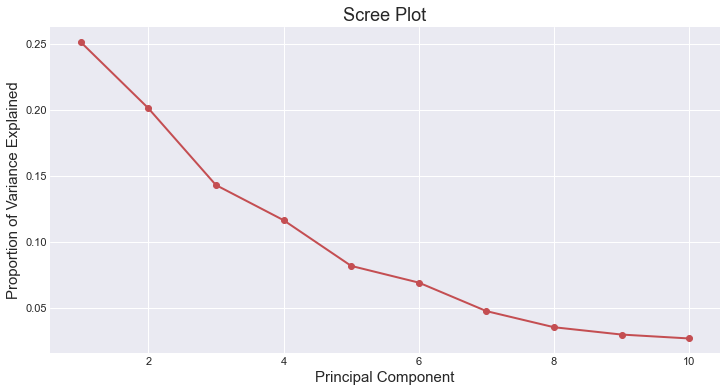

In [357]:
#Plot a Scree plot - get the dataframe for exp_variance_ratio
pca_df = pd.DataFrame(data = exp_variance_ratio)
pca_df.index = pca_df.index + 1

#Plot a Scree plot
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(12, 6))

plt.plot(pca_df, 'ro-', linewidth=2)
plt.title('Scree Plot', fontsize=18)
plt.xlabel('Principal Component', fontsize=15)
plt.ylabel('Proportion of Variance Explained', fontsize=15)
plt.show()

In [358]:
# from above, the optimal is n_components=2
pca = PCA(n_components=2)
result_pca = pca.fit_transform(X)

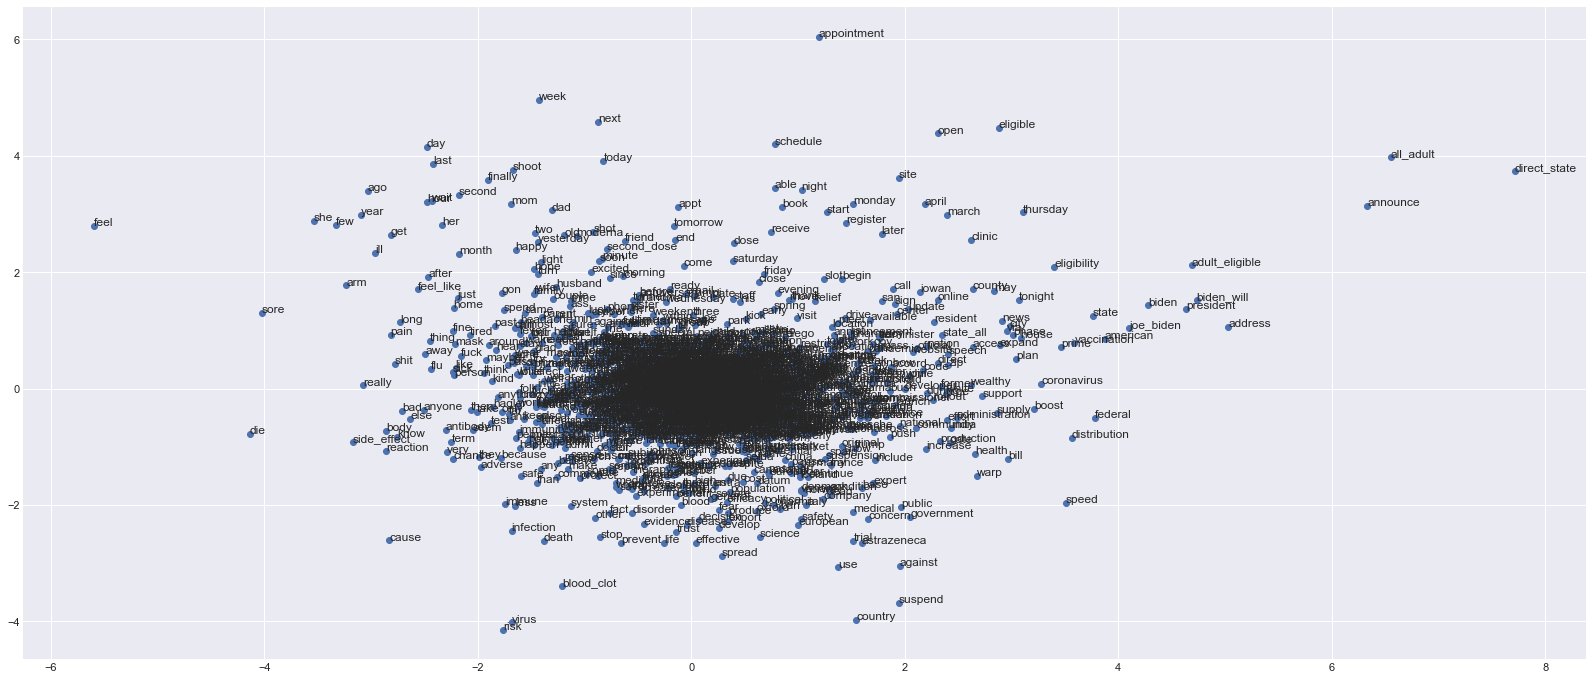

In [359]:
# create a scatter plot of the 2D projection
plt.figure(figsize=(28, 12))

x_pca = result_pca[:, 0]
y_pca = result_pca[:, 1]
plt.scatter(x_pca, y_pca)

words = list(W2V_model.wv.vocab)

for i, word in enumerate(words):
    plt.annotate(word, xy=(result_pca[i, 0], result_pca[i, 1]))
    
plt.show()

### tSNE 

In [360]:
# fit a 2d tSNE model to the vectors
tsne = TSNE(n_components=2)  # 2 = Dimension of the embedded space
result_tsne = tsne.fit_transform(X)

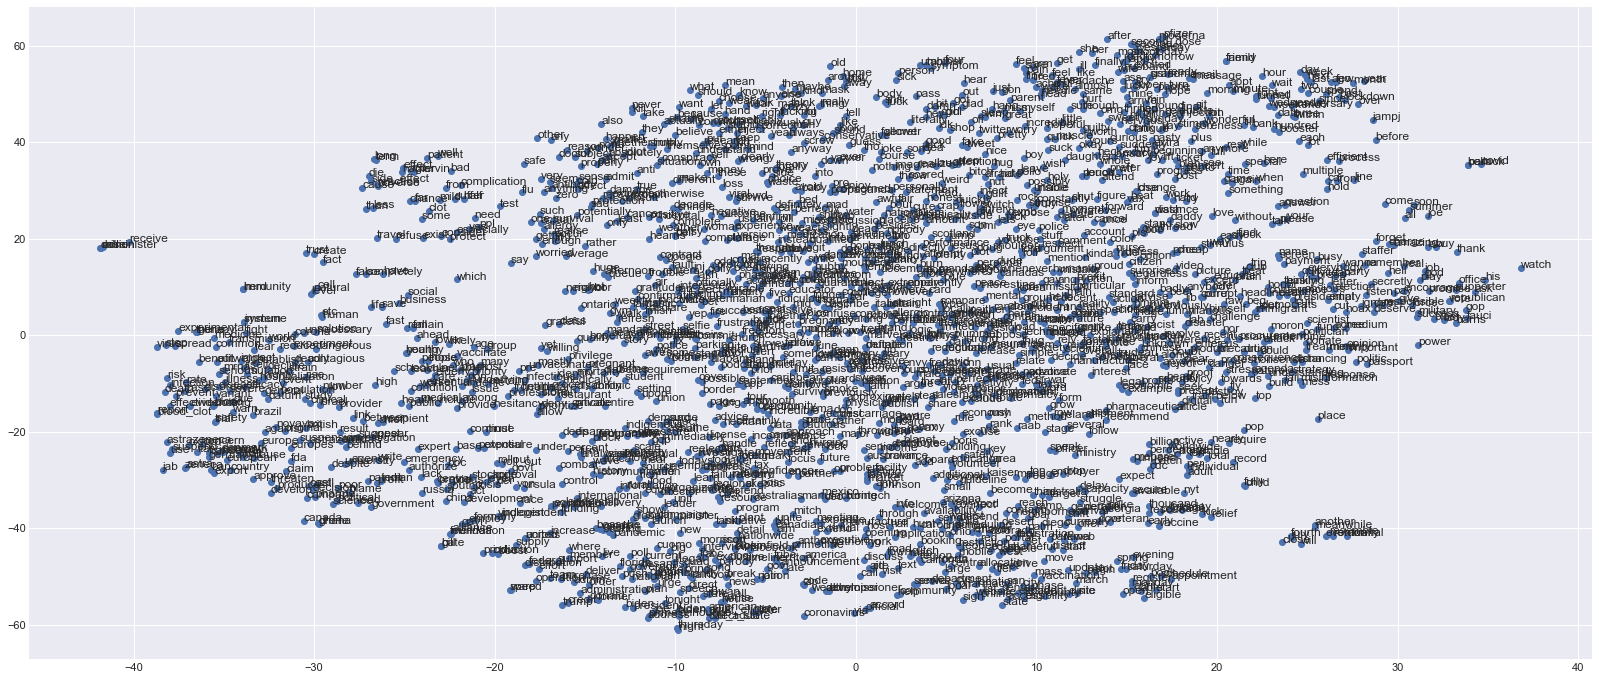

In [361]:
# create a scatter plot of the 2D projection
plt.figure(figsize=(28, 12))

x_tsne = result_tsne[:, 0]
y_tsne = result_tsne[:, 1]
plt.scatter(x_tsne, y_tsne)

words = list(W2V_model.wv.vocab)

for i, word in enumerate(words):
    plt.annotate(word, xy=(result_tsne[i, 0], result_tsne[i, 1]))
    
plt.show()
# shows better dimensionality reduction than PCA (less dense)

## Clustering 

### BIRCH

In [362]:
from sklearn.cluster import Birch

In [418]:
# Our Birch model (a)
brc = Birch(branching_factor=100, threshold=1.2, n_clusters=30)
brc.fit(X)

Birch(branching_factor=100, compute_labels=True, copy=True, n_clusters=30,
      threshold=1.2)

In [419]:
# We use the model to predict the respective clusters
cluster_brc = brc.predict(X)

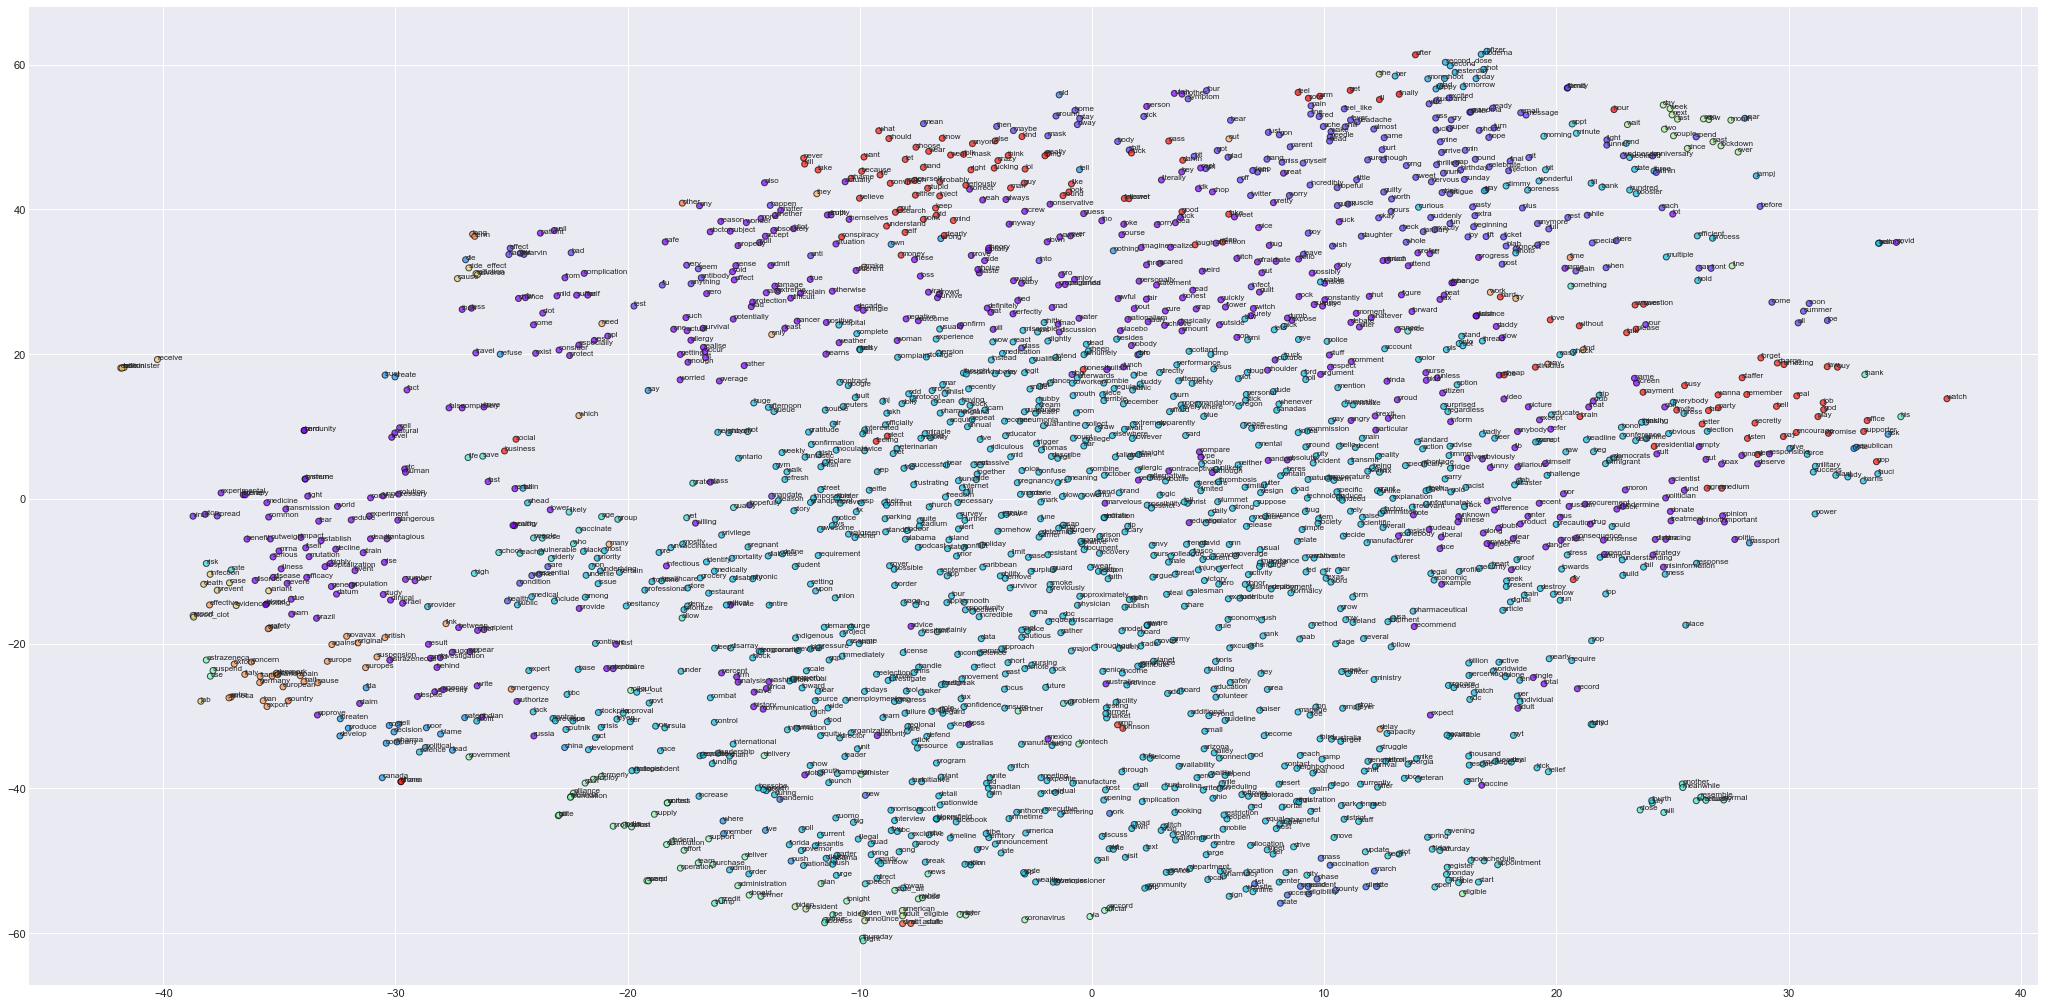

In [420]:
# create a scatter plot of the 2D projection
plt.figure(figsize=(36, 18))

x_tsne = result_tsne[:, 0]
y_tsne = result_tsne[:, 1]
plt.scatter(x_tsne, y_tsne, c=cluster_brc, cmap='rainbow', alpha=0.7, edgecolors='black')

words = list(W2V_model.wv.vocab)

for i, word in enumerate(words):
    plt.annotate(word, xy=(result_tsne[i, 0], result_tsne[i, 1]), fontsize=8)
    
plt.show()

In [421]:
# saving word vectors x and y coordinates in a dataframe
word_vec_dict = { "word": words,
                  "x": x_tsne,
                  "y": y_tsne,
                  "clusters_birch": cluster_brc}

word_coord = pd.DataFrame.from_dict(word_vec_dict)
word_coord.head(10)

word          x          y  clusters_birch
0      low -29.156960 -11.295184               0
1    covid  34.644394  35.451366               0
2     case -37.149780 -11.592671              20
3     mean  -7.255166  51.856754               2
4     open  14.770314 -53.618896               9
5     lets   7.850780  23.376778               8
6    start  16.645639 -52.935310               9
7     mass   9.869405 -49.653114               4
8  vaccine  16.788992 -39.560406               0
9   ensure  -3.757581 -28.901228               8

In [422]:
# see total number of clusters and how many words in each cluster
word_coord[['clusters_birch', 'word']].groupby('clusters_birch').count()

word
clusters_birch      
0                415
1                  7
2                152
3                  5
4                 16
5                  3
6                 33
7                 14
8                903
9                 34
10                16
11                16
12                 4
13                 6
14                 3
15                41
16                 4
17                15
18                 6
19                 1
20                13
21                 4
22                11
23                29
24                 3
25                 2
26                 2
27                 2
28               110
29                 8

In [368]:
# saving dataframe into csv to be exported into Tableau
word_coord.to_csv('wordvec_output.csv', index=False)

### KMeans 

In [369]:
## Getting optimal K for KMeans model
# ANSWER
inertias = []

# for clusters k=1 to k=20
K = range(1, 30)

for k in K:
    # Building and fitting the model
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    # append the inertia into a list
    inertias.append(kmeans.inertia_)

In [370]:
# Getting the inertia
inertias

[9463.919,
 8425.624812948692,
 7772.869424818569,
 7277.133277009836,
 6879.95545373347,
 6536.795540379843,
 6291.573250154054,
 6106.677591893055,
 5946.995466503218,
 5790.811555667495,
 5629.302665465637,
 5517.736640215979,
 5428.839110071742,
 5281.089957943029,
 5214.299278278679,
 5093.5275909729025,
 5060.694651578977,
 4947.562596174905,
 4880.714671868557,
 4795.569809880905,
 4750.711084842038,
 4676.406122041626,
 4597.716780058769,
 4541.322563729033,
 4478.556092306534,
 4459.529828242394,
 4413.793805707633,
 4357.517521105066,
 4304.914320064545]

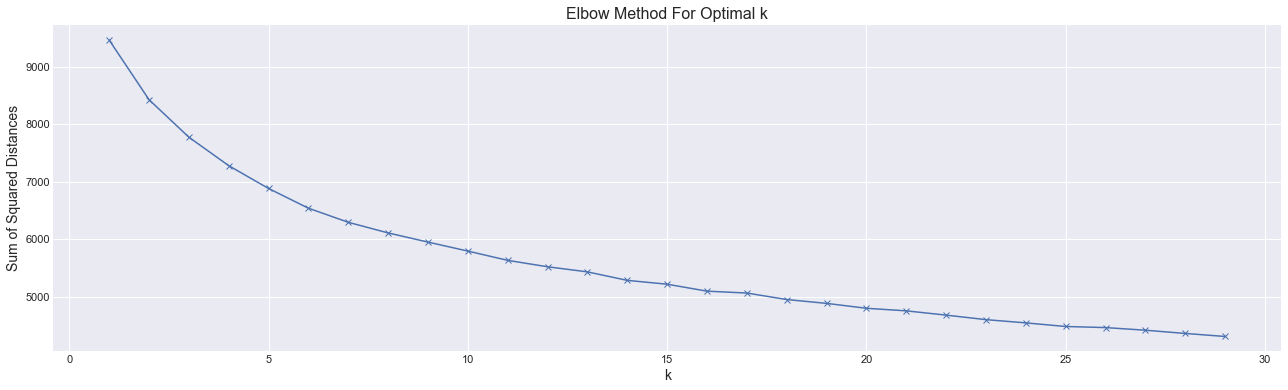

In [371]:
## Plotting the elbow: 
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(22, 6))
# Plotting k against Sum of Squared Distances
plt.plot(K, inertias, 'bx-')
plt.xlabel('k', fontsize=14)
plt.ylabel('Sum of Squared Distances', fontsize=14)
plt.title('Elbow Method For Optimal k', fontsize=16)
plt.show()

# not a clear elbow

In [372]:
# Our KMeans model
kms = KMeans(n_clusters=14)
kms.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=14, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [373]:
# We use the model to predict the respective clusters
cluster_kms = kms.predict(X)

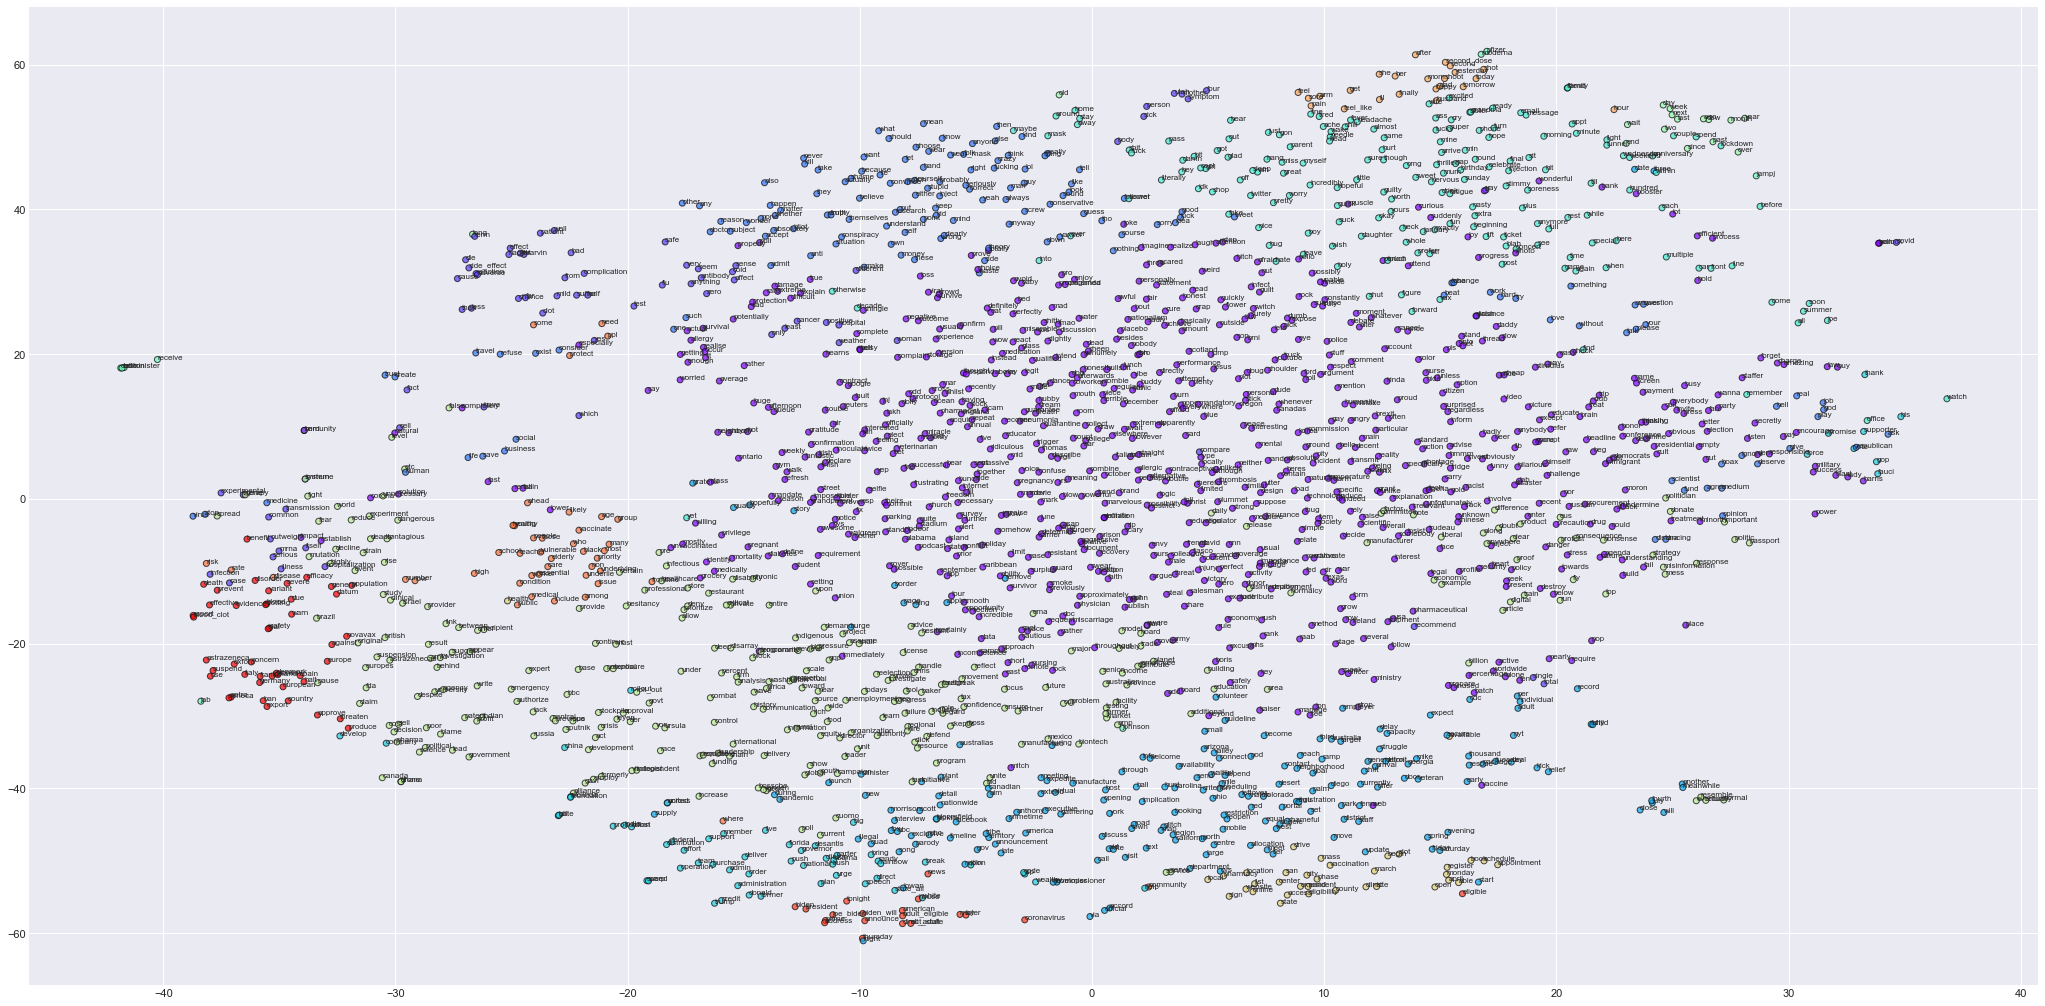

In [374]:
# create a scatter plot of the 2D projection
plt.figure(figsize=(36, 18))

x_tsne = result_tsne[:, 0]
y_tsne = result_tsne[:, 1]
plt.scatter(x_tsne, y_tsne, c=cluster_kms, cmap='rainbow', alpha=0.7, edgecolors='black')

words = list(W2V_model.wv.vocab)

for i, word in enumerate(words):
    plt.annotate(word, xy=(result_tsne[i, 0], result_tsne[i, 1]), fontsize=8)
    
plt.show()

In [423]:
# saving word vectors x and y coordinates in a dataframe
word_vec_dict = { "word": words,
                  "x": x_tsne,
                  "y": y_tsne,
                  "clusters_birch": cluster_brc,
                  "clusters_kms": cluster_kms}

word_coord = pd.DataFrame.from_dict(word_vec_dict)
word_coord.head(10)

word          x          y  clusters_birch  clusters_kms
0      low -29.156960 -11.295184               0            11
1    covid  34.644394  35.451366               0             1
2     case -37.149780 -11.592671              20             1
3     mean  -7.255166  51.856754               2             2
4     open  14.770314 -53.618896               9             9
5     lets   7.850780  23.376778               8             0
6    start  16.645639 -52.935310               9             3
7     mass   9.869405 -49.653114               4             9
8  vaccine  16.788992 -39.560406               0             0
9   ensure  -3.757581 -28.901228               8             8

In [424]:
# see total number of clusters and how many words in each cluster
word_coord[['clusters_kms', 'word']].groupby('clusters_kms').count()

word
clusters_kms      
0              756
1               72
2              151
3              186
4               63
5              171
6                9
7               16
8              288
9               35
10              23
11              44
12              19
13              45

In [425]:
# saving dataframe into csv to be exported into Tableau
word_coord.to_csv('wordvec_output.csv', index=False)

### Agglomerative Clustering 

In [426]:
from sklearn.cluster import AgglomerativeClustering

In [433]:
# Our AgglomerativeClustering model
aglo = AgglomerativeClustering(n_clusters=30)
aglo.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=30)

In [434]:
# We use the model to predict the respective clusters
cluster_aglo = aglo.fit_predict(X)

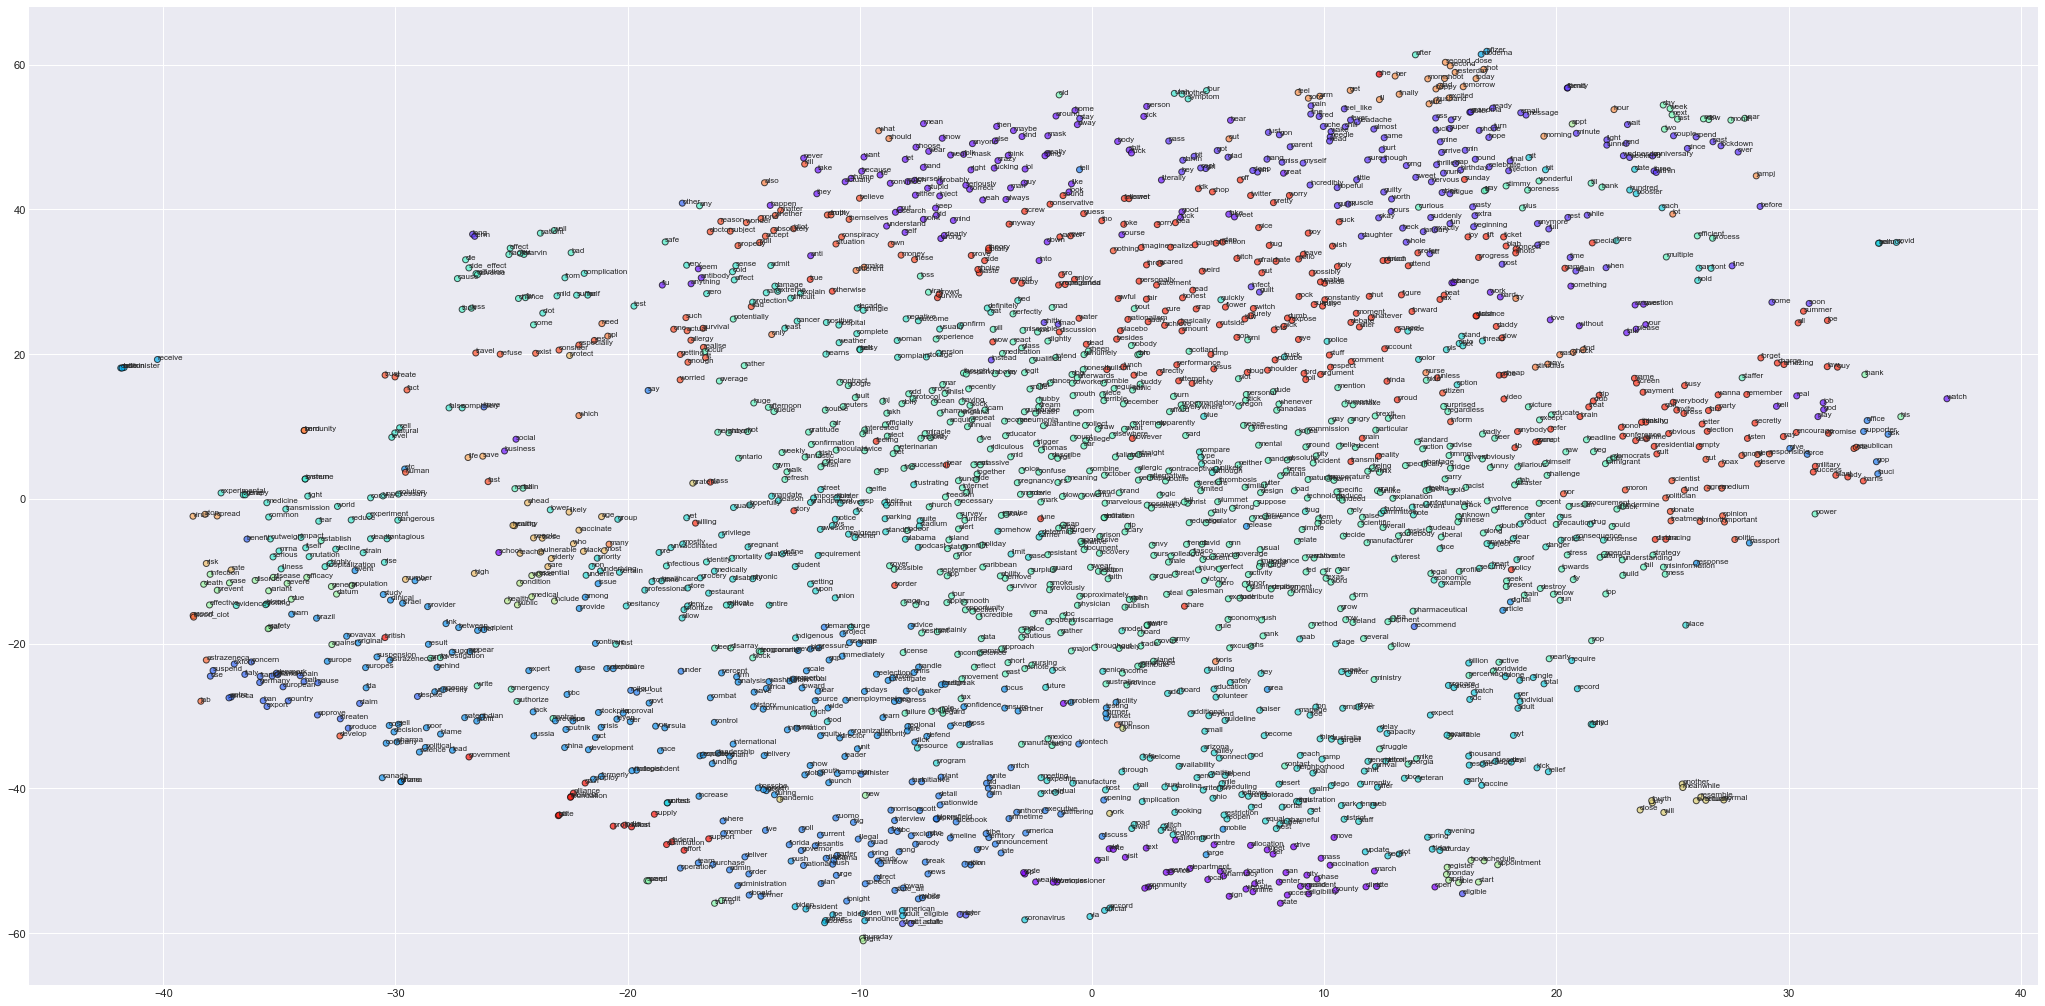

In [435]:
# create a scatter plot of the 2D projection
plt.figure(figsize=(36, 18))

x_tsne = result_tsne[:, 0]
y_tsne = result_tsne[:, 1]
plt.scatter(x_tsne, y_tsne, c=cluster_aglo, cmap='rainbow', alpha=0.7, edgecolors='black')

words = list(W2V_model.wv.vocab)

for i, word in enumerate(words):
    plt.annotate(word, xy=(result_tsne[i, 0], result_tsne[i, 1]), fontsize=8)
    
plt.show()

In [436]:
# saving word vectors x and y coordinates in a dataframe
word_vec_dict = { "word": words,
                  "x": x_tsne,
                  "y": y_tsne,
                  "clusters_birch": cluster_brc,
                  "clusters_kms": cluster_kms,
                  "clusters_aglo": cluster_aglo}

word_coord = pd.DataFrame.from_dict(word_vec_dict)
word_coord.head(10)

word          x          y  clusters_birch  clusters_kms  clusters_aglo
0      low -29.156960 -11.295184               0            11              6
1    covid  34.644394  35.451366               0             1              9
2     case -37.149780 -11.592671              20             1             16
3     mean  -7.255166  51.856754               2             2              1
4     open  14.770314 -53.618896               9             9              0
5     lets   7.850780  23.376778               8             0             27
6    start  16.645639 -52.935310               9             3             17
7     mass   9.869405 -49.653114               4             9              0
8  vaccine  16.788992 -39.560406               0             0              9
9   ensure  -3.757581 -28.901228               8             8              6

In [437]:
# see total number of clusters and how many words in each cluster
word_coord[['clusters_kms', 'word']].groupby('clusters_kms').count()

word
clusters_kms      
0              756
1               72
2              151
3              186
4               63
5              171
6                9
7               16
8              288
9               35
10              23
11              44
12              19
13              45

In [438]:
# saving dataframe into csv to be exported into Tableau
word_coord.to_csv('wordvec_output.csv', index=False)

In [445]:
# Agglomerative Clustering gave the best (most intuitive) clusters, so I will use that

## Word Proximity 

In [440]:
# create a proximity score of each word
t = time()

model = W2V_model
# word = 'homer'

arrays = np.empty((0, 100), dtype='f')
word_filters = []
word_labels = []
target_word  = []
proximity_score = []
count = 1.0
for word in model.wv.vocab:
    print(word,'||','time_now:{} mins'.format(round((time() - t) / 60, 2)),'||', '{}% Completed'.format(round(100.0 * count / float(len(model.wv.vocab)))))
    # adds the vector of the query word
    word_filters.append(word)
    word_labels.append(word)
    target_word.append(1)
    proximity_score.append(1.0)
    wrd_vector = model.wv.__getitem__([word])
    arrays = np.append(arrays, wrd_vector, axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        word_filters.append(word)
        word_labels.append(wrd_score[0])
        target_word.append(0)
        proximity_score.append(wrd_score[1])
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    count += 1

low || time_now:0.0 mins || 0% Completed
covid || time_now:0.0 mins || 0% Completed
case || time_now:0.0 mins || 0% Completed
mean || time_now:0.0 mins || 0% Completed
open || time_now:0.0 mins || 0% Completed
lets || time_now:0.0 mins || 0% Completed
start || time_now:0.0 mins || 0% Completed
mass || time_now:0.0 mins || 0% Completed
vaccine || time_now:0.0 mins || 0% Completed
ensure || time_now:0.0 mins || 1% Completed
summer || time_now:0.0 mins || 1% Completed
track || time_now:0.0 mins || 1% Completed
ocean || time_now:0.0 mins || 1% Completed
county || time_now:0.0 mins || 1% Completed
stick || time_now:0.0 mins || 1% Completed
find || time_now:0.0 mins || 1% Completed
appointment || time_now:0.0 mins || 1% Completed
hard || time_now:0.0 mins || 1% Completed
schedule || time_now:0.0 mins || 1% Completed
soon || time_now:0.0 mins || 1% Completed
finally || time_now:0.0 mins || 1% Completed
guarantee || time_now:0.0 mins || 1% Completed
ill || time_now:0.0 mins || 1% Completed
wea

give || time_now:0.01 mins || 11% Completed
out || time_now:0.01 mins || 11% Completed
wife || time_now:0.01 mins || 11% Completed
really || time_now:0.01 mins || 11% Completed
pay || time_now:0.01 mins || 11% Completed
having || time_now:0.01 mins || 11% Completed
connect || time_now:0.01 mins || 11% Completed
never || time_now:0.01 mins || 11% Completed
mask || time_now:0.01 mins || 11% Completed
good || time_now:0.01 mins || 12% Completed
somebody || time_now:0.01 mins || 12% Completed
type || time_now:0.01 mins || 12% Completed
yeah || time_now:0.01 mins || 12% Completed
hear || time_now:0.01 mins || 12% Completed
need || time_now:0.01 mins || 12% Completed
confirm || time_now:0.01 mins || 12% Completed
patient || time_now:0.01 mins || 12% Completed
miss || time_now:0.01 mins || 12% Completed
second || time_now:0.01 mins || 12% Completed
provider || time_now:0.01 mins || 12% Completed
waste || time_now:0.01 mins || 12% Completed
true || time_now:0.01 mins || 12% Completed
look || t

teacher || time_now:0.05 mins || 21% Completed
coronavirus || time_now:0.05 mins || 21% Completed
announce || time_now:0.05 mins || 21% Completed
reelection || time_now:0.05 mins || 21% Completed
bid || time_now:0.05 mins || 21% Completed
unite || time_now:0.05 mins || 21% Completed
opening || time_now:0.05 mins || 21% Completed
mile || time_now:0.05 mins || 21% Completed
target || time_now:0.05 mins || 21% Completed
store || time_now:0.05 mins || 21% Completed
todays || time_now:0.05 mins || 21% Completed
top || time_now:0.05 mins || 21% Completed
story || time_now:0.05 mins || 22% Completed
politic || time_now:0.05 mins || 22% Completed
list || time_now:0.05 mins || 22% Completed
argument || time_now:0.05 mins || 22% Completed
fake || time_now:0.05 mins || 22% Completed
tax || time_now:0.05 mins || 22% Completed
fund || time_now:0.05 mins || 22% Completed
profile || time_now:0.06 mins || 22% Completed
expose || time_now:0.06 mins || 22% Completed
irrelevant || time_now:0.06 mins || 2

directly || time_now:0.14 mins || 31% Completed
hand || time_now:0.14 mins || 31% Completed
airline || time_now:0.14 mins || 31% Completed
push || time_now:0.14 mins || 31% Completed
hell || time_now:0.14 mins || 31% Completed
yesterday || time_now:0.14 mins || 31% Completed
throw || time_now:0.14 mins || 31% Completed
together || time_now:0.14 mins || 31% Completed
pull || time_now:0.14 mins || 31% Completed
eat || time_now:0.14 mins || 31% Completed
bar || time_now:0.14 mins || 31% Completed
college || time_now:0.14 mins || 31% Completed
side_effect || time_now:0.14 mins || 31% Completed
reduction || time_now:0.14 mins || 31% Completed
white || time_now:0.14 mins || 32% Completed
blood || time_now:0.14 mins || 32% Completed
cell || time_now:0.14 mins || 32% Completed
infection || time_now:0.14 mins || 32% Completed
hunt || time_now:0.14 mins || 32% Completed
doctor || time_now:0.14 mins || 32% Completed
link || time_now:0.15 mins || 32% Completed
understand || time_now:0.15 mins || 3

complication || time_now:0.25 mins || 40% Completed
underlie || time_now:0.25 mins || 40% Completed
very || time_now:0.25 mins || 40% Completed
quickly || time_now:0.25 mins || 40% Completed
experience || time_now:0.26 mins || 41% Completed
miscarriage || time_now:0.26 mins || 41% Completed
adverse || time_now:0.26 mins || 41% Completed
run || time_now:0.26 mins || 41% Completed
fda || time_now:0.26 mins || 41% Completed
investigate || time_now:0.26 mins || 41% Completed
email || time_now:0.26 mins || 41% Completed
busy || time_now:0.26 mins || 41% Completed
worker || time_now:0.26 mins || 41% Completed
lady || time_now:0.26 mins || 41% Completed
deserve || time_now:0.26 mins || 41% Completed
three || time_now:0.26 mins || 41% Completed
refuse || time_now:0.26 mins || 41% Completed
qualify || time_now:0.27 mins || 41% Completed
stimulus || time_now:0.27 mins || 41% Completed
nice || time_now:0.27 mins || 41% Completed
twice || time_now:0.27 mins || 41% Completed
min || time_now:0.27 mi

indoor || time_now:0.41 mins || 50% Completed
however || time_now:0.42 mins || 50% Completed
unvaccinated || time_now:0.42 mins || 50% Completed
precaution || time_now:0.42 mins || 50% Completed
doubt || time_now:0.42 mins || 50% Completed
guideline || time_now:0.42 mins || 50% Completed
meet || time_now:0.42 mins || 50% Completed
web || time_now:0.42 mins || 50% Completed
color || time_now:0.42 mins || 50% Completed
australian || time_now:0.43 mins || 50% Completed
arrive || time_now:0.43 mins || 50% Completed
volunteer || time_now:0.43 mins || 51% Completed
hour || time_now:0.43 mins || 51% Completed
contact || time_now:0.43 mins || 51% Completed
multiple || time_now:0.43 mins || 51% Completed
shift || time_now:0.43 mins || 51% Completed
sit || time_now:0.43 mins || 51% Completed
fucking || time_now:0.43 mins || 51% Completed
clinic || time_now:0.43 mins || 51% Completed
provide || time_now:0.43 mins || 51% Completed
reach || time_now:0.44 mins || 51% Completed
big || time_now:0.44 m

possibility || time_now:0.6 mins || 60% Completed
payment || time_now:0.6 mins || 60% Completed
idiot || time_now:0.6 mins || 60% Completed
rare || time_now:0.6 mins || 60% Completed
couple || time_now:0.6 mins || 60% Completed
standby || time_now:0.6 mins || 60% Completed
pass || time_now:0.6 mins || 60% Completed
lmao || time_now:0.6 mins || 60% Completed
hold || time_now:0.6 mins || 60% Completed
conference || time_now:0.61 mins || 60% Completed
border || time_now:0.61 mins || 60% Completed
mandate || time_now:0.61 mins || 60% Completed
injury || time_now:0.61 mins || 60% Completed
june || time_now:0.61 mins || 60% Completed
remember || time_now:0.61 mins || 60% Completed
contract || time_now:0.61 mins || 60% Completed
everybody || time_now:0.61 mins || 60% Completed
front || time_now:0.61 mins || 60% Completed
door || time_now:0.61 mins || 60% Completed
intellectual || time_now:0.61 mins || 61% Completed
property || time_now:0.61 mins || 61% Completed
manufacture || time_now:0.61 m

victory || time_now:0.74 mins || 69% Completed
gold || time_now:0.74 mins || 69% Completed
particular || time_now:0.74 mins || 69% Completed
narrative || time_now:0.74 mins || 69% Completed
switch || time_now:0.74 mins || 69% Completed
agenda || time_now:0.74 mins || 69% Completed
follower || time_now:0.75 mins || 70% Completed
protest || time_now:0.75 mins || 70% Completed
identify || time_now:0.75 mins || 70% Completed
fault || time_now:0.75 mins || 70% Completed
history || time_now:0.75 mins || 70% Completed
washington || time_now:0.75 mins || 70% Completed
acquire || time_now:0.75 mins || 70% Completed
item || time_now:0.75 mins || 70% Completed
neither || time_now:0.76 mins || 70% Completed
nor || time_now:0.76 mins || 70% Completed
generation || time_now:0.76 mins || 70% Completed
powerful || time_now:0.76 mins || 70% Completed
plus || time_now:0.76 mins || 70% Completed
besides || time_now:0.76 mins || 70% Completed
advise || time_now:0.76 mins || 70% Completed
step || time_now:

active || time_now:0.93 mins || 79% Completed
detail || time_now:0.93 mins || 79% Completed
selfie || time_now:0.93 mins || 79% Completed
approval || time_now:0.93 mins || 79% Completed
necessary || time_now:0.93 mins || 79% Completed
weekly || time_now:0.94 mins || 79% Completed
humanity || time_now:0.94 mins || 79% Completed
level || time_now:0.94 mins || 79% Completed
georgia || time_now:0.94 mins || 79% Completed
leadership || time_now:0.94 mins || 79% Completed
alter || time_now:0.94 mins || 79% Completed
fix || time_now:0.94 mins || 79% Completed
officially || time_now:0.94 mins || 79% Completed
bet || time_now:0.94 mins || 79% Completed
restriction || time_now:0.94 mins || 79% Completed
lift || time_now:0.95 mins || 79% Completed
shall || time_now:0.95 mins || 79% Completed
grandma || time_now:0.95 mins || 80% Completed
quarantine || time_now:0.95 mins || 80% Completed
unnecessary || time_now:0.95 mins || 80% Completed
round || time_now:0.95 mins || 80% Completed
breath || time_

celebrate || time_now:1.08 mins || 88% Completed
build || time_now:1.09 mins || 88% Completed
skeptic || time_now:1.09 mins || 88% Completed
burn || time_now:1.09 mins || 88% Completed
fourth || time_now:1.09 mins || 88% Completed
draw || time_now:1.09 mins || 88% Completed
freedom || time_now:1.09 mins || 89% Completed
resemble || time_now:1.09 mins || 89% Completed
survivor || time_now:1.09 mins || 89% Completed
usual || time_now:1.09 mins || 89% Completed
adult_eligible || time_now:1.09 mins || 89% Completed
original || time_now:1.09 mins || 89% Completed
british || time_now:1.09 mins || 89% Completed
attempt || time_now:1.1 mins || 89% Completed
launch || time_now:1.1 mins || 89% Completed
stage || time_now:1.1 mins || 89% Completed
state_all || time_now:1.1 mins || 89% Completed
buddy || time_now:1.1 mins || 89% Completed
prefer || time_now:1.1 mins || 89% Completed
war || time_now:1.1 mins || 89% Completed
nap || time_now:1.1 mins || 89% Completed
pregnancy || time_now:1.1 mins |

confidence || time_now:1.25 mins || 98% Completed
unlike || time_now:1.25 mins || 98% Completed
third || time_now:1.25 mins || 98% Completed
equal || time_now:1.25 mins || 98% Completed
surprised || time_now:1.25 mins || 98% Completed
chinese || time_now:1.25 mins || 98% Completed
successful || time_now:1.25 mins || 98% Completed
theory || time_now:1.25 mins || 98% Completed
deadly || time_now:1.25 mins || 98% Completed
click || time_now:1.26 mins || 98% Completed
trace || time_now:1.26 mins || 98% Completed
indian || time_now:1.26 mins || 98% Completed
slightly || time_now:1.26 mins || 98% Completed
inoculate || time_now:1.26 mins || 98% Completed
spain || time_now:1.26 mins || 98% Completed
ireland || time_now:1.26 mins || 98% Completed
gqp || time_now:1.26 mins || 99% Completed
roll || time_now:1.26 mins || 99% Completed
shameful || time_now:1.26 mins || 99% Completed
pill || time_now:1.26 mins || 99% Completed
restrict || time_now:1.27 mins || 99% Completed
mitch || time_now:1.27 m

In [441]:
word_prox = pd.DataFrame({'word_filters': word_filters,
                   'word': word_labels,
                   'is_target_word': target_word,
                   'proximity_score': proximity_score})

In [442]:
word_prox.shape

(20658, 4)

In [443]:
word_prox.head()

word_filters        word  is_target_word  proximity_score
0          low         low               1         1.000000
1          low     disease               0         0.891554
2          low        high               0         0.890495
3          low  underlying               0         0.881423
4          low   mortality               0         0.879335

In [444]:
# saving dataframe into csv to be exported into Tableau
word_prox.to_csv('wordprox_output.csv', index=False)

# Fake News

With regards to Covid-19 vaccines, there are many misinformation out there. I have compiled a list of 'fake news' or 'rumours' about the vaccine which have been debunked over March 2021. We will see what keywords they contain.

In [446]:
# list of fake news articles that we know have been debunked
fake_news_list = ["vaccine will change one's genes - altered DNA",
                  "vaccine results in cancer a few years down the road",
                  "AstraZeneca COVID-19 vaccine causes blood clots",
                  "vaccine that caused Marvin Hagler's death",
                  "J&J COVID-19 Vaccine Contain Aborted Fetal Cells",
                  "vaccines make you infertile",
                  "Bill Gates will use microchip implants to fight coronavirus"]

## Data Processing

In [448]:
# lemmatise, remove stopwords, lowercase, remove punctuations
fake_sent = lemmatize(str(fake_news_list))
fake_sent

['vaccine',
 'will',
 'change',
 'gene',
 'alter',
 'dna',
 'vaccine',
 'result',
 'cancer',
 'few',
 'year',
 'down',
 'road',
 'astrazeneca',
 'vaccine',
 'cause',
 'blood',
 'clot',
 'vaccine',
 'cause',
 'marvin',
 'hagler',
 'death',
 'vaccine',
 'contain',
 'aborted',
 'fetal',
 'cells',
 'vaccine',
 'infertile',
 'bill',
 'gates',
 'will',
 'use',
 'microchip',
 'implant',
 'fight',
 'coronavirus']

## Word Frequency 

In [537]:
fake_word_freq = collections.Counter(fake_sent)
print(fake_word_freq)

Counter({'vaccine': 6, 'will': 2, 'cause': 2, 'change': 1, 'gene': 1, 'alter': 1, 'dna': 1, 'result': 1, 'cancer': 1, 'few': 1, 'year': 1, 'down': 1, 'road': 1, 'astrazeneca': 1, 'blood': 1, 'clot': 1, 'marvin': 1, 'hagler': 1, 'death': 1, 'contain': 1, 'aborted': 1, 'fetal': 1, 'cells': 1, 'infertile': 1, 'bill': 1, 'gates': 1, 'use': 1, 'microchip': 1, 'implant': 1, 'fight': 1, 'coronavirus': 1})


In [538]:
# unique list of words from fake news
fake_list = list(fake_word_freq.keys())

In [540]:
fake_list.remove('coronavirus')  # neutral words/ topic words, to be removed

In [541]:
fake_list.remove('vaccine') # neutral words/ topic words, to be removed

In [542]:
fake_list

['will',
 'change',
 'gene',
 'alter',
 'dna',
 'result',
 'cancer',
 'few',
 'year',
 'down',
 'road',
 'astrazeneca',
 'cause',
 'blood',
 'clot',
 'marvin',
 'hagler',
 'death',
 'contain',
 'aborted',
 'fetal',
 'cells',
 'infertile',
 'bill',
 'gates',
 'use',
 'microchip',
 'implant',
 'fight']

## Check if Original Vocab contain Fake Words 

In [543]:
def check(text):
# Checking if text exists in list  
    if (text in fake_list): 
        return True
    else:
        return False

In [544]:
# Applying function to original dataframe
word_coord['fake_check'] = word_coord['word'].apply(check)

In [557]:
# check which words appear in fake list
fake_words_df = word_coord[(word_coord.fake_check == True)]
fake_words_df

word          x          y  clusters_birch  clusters_kms  \
26           year  28.116594  52.601898               5             7   
28            use -37.971725 -24.487438              14            13   
124        result -28.580509 -20.084974               0             8   
133           few  26.562679  52.426258              17             7   
243   astrazeneca -38.145809 -22.258963              14            13   
263         death -38.258820 -11.784731              20            13   
331         cause -27.330265  30.452597              20             1   
592         blood -35.545773 -14.495422               0            13   
638          will  24.630491 -43.320477              11             3   
824          down  -1.929857  35.520573               0             2   
875          bill -22.985466 -43.764919              15             4   
892        change  15.583185  29.900944               0             2   
1139          dna  24.713032  -5.576384               0             2   
1151      contain   8.123746   3.207201               8             0   
1167        fight -33.777943   0.384837               0             8   
1172         road   1.816018 -44.975903               8             3   
1442         gene -36.468182   0.572126               0             8   
1486        alter  11.517283  23.765257               0             0   
1504       cancer -12.698604  24.567778               0             1   
1731         clot -23.654640  25.684067               0             1   
1810       hagler -25.115257  33.778397               2             1   
1824       marvin -24.465029  33.793297               2             1   

      clusters_aglo  fake_check  
26               14        True  
28                4        True  
124               6        True  
133              14        True  
243              25        True  
263              16        True  
331              12        True  
592              11        True  
638              20        True  
824               1        True  
875              28        True  
892               1        True  
1139             27        True  
1151             13        True  
1167             11        True  
1172             10        True  
1442             11        True  
1486             27        True  
1504             11        True  
1731             11        True  
1810             12        True  
1824             12        True

## Fake Clusters Check 

In [558]:
# how many fakes words are in the clusters?
fake_words_df.groupby('clusters_aglo').size()

clusters_aglo
1     2
4     1
6     1
10    1
11    5
12    3
13    1
14    2
16    1
20    1
25    1
27    2
28    1
dtype: int64

In [569]:
# how many clusters contain fake words? 
len(fake_words_df.groupby('clusters_aglo')['word'].nunique())
# 13 out of 30 clusters contain fake words

13

In [553]:
# saving dataframe into csv to be exported into Tableau
word_coord.to_csv('wordvec_output.csv', index=False)

In [ ]:
# do a cosine similarity on the article level (proximity)